In [2]:
import numpy as np
import scipy as sc
import random as rand
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import arange, argsort, cumsum, diag, identity, ones
from scipy.linalg import block_diag
from matplotlib.pyplot import figure
from numpy import array, zeros
from scipy.integrate import solve_ivp
from matplotlib.pyplot import figure
from numpy import arange, array, dot, reshape, zeros
from numpy.linalg import solve
from torch import is_tensor, tensor
from warnings import warn
from numpy import array, concatenate, dot, reshape, tensordot, zeros
import numpy as np
import scipy.sparse as sparse
from scipy.signal import cont2discrete
import osqp
from numpy import array, interp, atleast_1d

from matplotlib.pyplot import figure, grid, legend, plot, show, subplot, suptitle, title, savefig, ylim, ylabel, xlabel
from numpy import array, gradient, zeros, tile
import numpy as np
import torch
from torch.nn.utils import prune

from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
from numpy import append, arange, arctan, array, concatenate, cos, reshape, sin, zeros
from tabulate import tabulate
import time
import os
import numpy as np
import osqp
from scipy import sparse
import importlib
from numba import jit
%pip install dill
import dill, os, torch
from matplotlib.ticker import MaxNLocator







[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:

class Dynamics:
    """Abstract dynamics class.

    Override eval, eval_dot.
    """

    def eval(self, x, t):
        """Compute representation.

        Inputs:
        State, x: numpy array
        Time, t: float

        Outputs:
        Representation: numpy array
        """

        pass

    def eval_dot(self, x, u, t):
        """Compute dynamics (time derivative of representation).

        Inputs:
        State, x: numpy array
        Action, u: numpy array
        Time, t: float

        Outputs:
        Time-derivative: numpy array
        """

        pass

In [4]:
from numpy import dot

class AffineDynamics(Dynamics):
    """Abstract class for dynamics of the form x_dot = f(x, t) + g(x, t) * u.

    Override eval, drift, act.
    """

    def drift(self, x, t):
        """Compute drift vector f(x, t).

        Inputs:
        State, x: numpy array
        Time, t: float

        Outputs:
        Drift vector: numpy array
        """

        pass

    def act(self, x, t):
        """Compute actuation matrix g(x, t).

        Inputs:
        State, x: numpy array
        Time, t: float

        Outputs:
        Actuation matrix: numpy array
        """

        pass

    def eval_dot(self, x, u, t):
        return self.drift(x, t) + dot(self.act(x, t), u)






In [5]:
class LinearizableDynamics(Dynamics):
    """Abstract class for dynamics with representations as x_dot = A * x + B * u.

    Override eval, eval_dot, linear_system.
    """

    def linear_system(self):
        """Compute matrices A and B in linear representation of dynamics.

        Outputs:
        A and B matrices: numpy array * numpy array
        """

        pass

    def closed_loop_linear_system(self, K):
        """Compute matrix A - B * K in linear representation of closed-loop dynamics.

        Inputs:
        Gain matrix, K: numpy array

        Outputs:
        Closed-loop matrix: numpy array
        """

        A, B = self.linear_system()
        return A - dot(B, K)


In [6]:
class SystemDynamics(Dynamics):
    """Abstract dynamics class for simulation.

    Override eval_dot.
    """

    def __init__(self, n, m):
        """Create a SystemDynamics object.

        Inputs:
        Number of states, n: int
        Number of actions, m: int
        """

        self.n = n
        self.m = m

    def eval(self, x, t):
        return x

    def step(self, x_0, u_0, t_0, t_f, atol=1e-6, rtol=1e-6):
        """Simulate system from initial state with constant action over a
        time interval.

        Approximated using Runge-Kutta 4,5 solver.

        Inputs:
        Initial state, x_0: numpy array
        Control action, u_0: numpy array
        Initial time, t_0: float
        Final time, t_f: float
        Absolute tolerance, atol: float
        Relative tolerance, rtol: float

        Outputs:
        State at final time: numpy array
        """

        x_dot = lambda t, x: self.eval_dot(x, u_0, t)
        t_span = [t_0, t_f]
        res = solve_ivp(x_dot, t_span, x_0, atol=atol, rtol=rtol)
        return res.y[:, -1]

    def simulate(self, x_0, controller, ts, processed=True, atol=1e-6, rtol=1e-6):
        """Simulate system from initial state with specified controller.

        Approximated using Runge-Kutta 4,5 solver.

        Actions computed at time steps and held constant over sample period.

        Inputs:
        Initial state, x_0: numpy array
        Control policy, controller: Controller
        Time steps, ts: numpy array
        Flag to process actions, processed: bool
        Absolute tolerance, atol: float
        Relative tolerance, rtol: float

        Outputs:
        State history: numpy array
        Action history: numpy array
        """

        N = len(ts)
        xs = zeros((N, self.n))
        us = [None] * (N - 1)

        controller.reset()

        xs[0] = x_0
        for j in range(N - 1):
            x = xs[j]
            t = ts[j]
            u = controller.eval(x, t)
            us[j] = u
            u = controller.process(u)
            xs[j + 1] = self.step(x, u, t, ts[j + 1])
        if processed:
            us = array([controller.process(u) for u in us])

        return xs, us

    def plot_timeseries(self, ts, data, fig=None, ax=None, title=None, labels=None):
        fig, ax = default_fig(fig, ax)

        if title is not None:
            ax.set_title(title, fontsize=16)

        ax.set_xlabel('$t$ (sec)', fontsize=16)
        ax.plot(ts, data, linewidth=3)

        if labels is not None:
            ax.legend(labels, fontsize=16)

        return fig, ax

    def plot_states(self, ts, xs, fig=None, ax=None, labels=None):
        if labels is None:
            labels = [f'$x_{i}$' for i in range(self.n)]

        return self.plot_timeseries(ts, xs, fig, ax, 'States', labels)

    def plot_actions(self, ts, us, fig=None, ax=None, labels=None):
        if labels is None:
            labels = [f'$u_{j}$' for j in range(self.m)]

        return self.plot_timeseries(ts[:-1], us, fig, ax, 'Actions', labels)

    def plot(self, xs, us, ts, fig=None, state_labels=None, action_labels=None):
        if fig is None:
            fig = figure(figsize=(12, 6), tight_layout=True)

        state_ax = fig.add_subplot(1, 2, 1)
        fig, state_ax = self.plot_states(ts, xs, fig, state_ax, state_labels)

        action_ax = fig.add_subplot(1, 2, 2)
        fig, action_ax = self.plot_actions(ts, us, fig, action_ax, action_labels)

        return fig, (state_ax, action_ax)

In [7]:
def arr_map(func, *arr):
    return array(list(map(func, *arr)))

def differentiate(xs, ts, L=3):
    half_L = (L - 1) // 2
    b = zeros(L)
    b[1] = 1

    def diff(xs, ts):
        t_0 = ts[half_L]
        t_diffs = reshape(ts - t_0, (L, 1))
        pows = reshape(arange(L), (1, L))
        A = (t_diffs ** pows).T
        w = solve(A, b)
        return dot(w, xs)

    return array([diff(xs[k - half_L:k + half_L + 1], ts[k - half_L:k + half_L + 1]) for k in range(half_L, len(ts) - half_L)])

def default_fig(fig, ax):
    if fig is None:
        fig = figure(figsize=(6, 6), tight_layout=True)

    if ax is None:
        ax = fig.add_subplot(1, 1, 1)

    return fig, ax

In [8]:
class LinearizableDynamics(Dynamics):
    """Abstract class for dynamics with representations as x_dot = A * x + B * u.

    Override eval, eval_dot, linear_system.
    """

    def linear_system(self):
        """Compute matrices A and B in linear representation of dynamics.

        Outputs:
        A and B matrices: numpy array * numpy array
        """

        pass

    def closed_loop_linear_system(self, K):
        """Compute matrix A - B * K in linear representation of closed-loop dynamics.

        Inputs:
        Gain matrix, K: numpy array

        Outputs:
        Closed-loop matrix: numpy array
        """

        A, B = self.linear_system()
        return A - dot(B, K)



In [9]:
class FBLinDynamics(AffineDynamics, LinearizableDynamics):
    """Abstract class for feedback linearizable affine dynamics.

    Representation must be block form, with each block corresponding to an
    output coordinate. If an output has relative degree gamma, then the
    corresponding block must express derivatives of order 0 through gamma - 1,
    in that order.

    If dynamics are specified in a different order, specify a permutation into
    block form.

    Override eval, drift, act.
    """

    def __init__(self, relative_degrees, perm=None):
        """Create an FBLinDynamics object.

        Inputs:
        Relative degrees of each output coordinate, relative_degrees: int list
        Indices of coordinates that make up each block, perm: numpy array
        """

        self.relative_degrees = relative_degrees
        self.relative_degree_idxs = cumsum(relative_degrees) - 1
        if perm is None:
            perm = arange(sum(relative_degrees))
        self.perm = perm
        self.inv_perm = argsort(perm)

    def select(self, arr):
        """Select coordinates of block order corresponding to highest-order derivatives.

        Inputs:
        Array, arr: numpy array

        Outputs:
        Array of selected coordinates: numpy array
        """

        return arr[self.relative_degree_idxs]

    def permute(self, arr):
        """Permute array into block order.

        Inputs:
        Array, arr: numpy array

        Outputs:
        Array permuted into block form: numpy array
        """

        return arr[self.perm]

    def inv_permute(self, arr):
        """Permute array out of block order.

        Inputs:
        Array in block form, arr: numpy array

        Outputs:
        Array out of block form: numpy array
        """

        return arr[self.inv_perm]

    def linear_system(self):
        F = block_diag(*[diag(ones(gamma - 1), 1) for gamma in self.relative_degrees])
        G = (identity(sum(self.relative_degrees))[self.relative_degree_idxs]).T

        F = (self.inv_permute((self.inv_permute(F)).T)).T
        G = self.inv_permute(G)

        return F, G


In [10]:
class PDDynamics(Dynamics):
    """Abstract class for dynamics with proportional and derivative components.

    Override eval, eval_dot, proportional, derivative.
    """

    def proportional(self, x, t):
        """Compute proportional component.

        Inputs:
        State, x: numpy array
        Time, t: float

        Outputs:
        Proportional component: numpy array
        """

        pass

    def derivative(self, x, t):
        """Compute derivative component.

        Inputs:
        State, x: numpy array
        Time, t: float

        Outputs:
        Derivative component: numpy array
        """

        pass

In [11]:
class ConfigurationDynamics(FBLinDynamics, PDDynamics):
    def __init__(self, robotic_dynamics, k):
        relative_degrees = [2] * k
        perm = concatenate([array([j, j + k]) for j in range(k)])
        FBLinDynamics.__init__(self, relative_degrees, perm)
        self.robotic_dynamics = robotic_dynamics
        self.k = k

    def y(self, q):
        pass

    def dydq(self, q):
        pass

    def d2ydq2(self, q):
        pass

    def y_d(self, t):
        return zeros(self.k)

    def y_d_dot(self, t):
        return zeros(self.k)

    def y_d_ddot(self, t):
        return zeros(self.k)

    def eval(self, x, t):
        return concatenate([self.proportional(x, t), self.derivative(x, t)])

    def drift(self, x, t):
        q, q_dot = reshape(x, (2, -1))
        q_ddot_drift = self.robotic_dynamics.drift(x, t)[self.robotic_dynamics.k:]
        err_ddot_drift = dot(tensordot(self.d2ydq2(q), q_dot, 1), q_dot) + dot(self.dydq(q), q_ddot_drift) - self.y_d_ddot(t)
        return concatenate([self.derivative(x, t), err_ddot_drift])

    def act(self, x, t):
        q = self.robotic_dynamics.proportional(x, t)
        q_ddot_act = self.robotic_dynamics.act(x, t)[self.robotic_dynamics.k:]
        return concatenate([zeros((self.k, self.robotic_dynamics.m)), dot(self.dydq(q), q_ddot_act)])

    def proportional(self, x, t):
        q = self.robotic_dynamics.proportional(x, t)
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = reshape(x, (2, -1))
        return dot(self.dydq(q), q_dot) - self.y_d_dot(t)


In [12]:
from torch import nn
class Controller(nn.Module):
    """Abstract policy class for control.

    Override forward.
    """

    def __init__(self, dynamics):
        """Create a Controller object.

        Inputs:
        Dynamics, dynamics: Dynamics
        """
        super().__init__()
        self.dynamics = dynamics

    def forward(self, x, t):
        """Compute general representation of an action.

        Inputs:
        State, x: numpy array
        Time, t: float

        Outputs:
        Action: object
        """

        pass

    def process(self, u):
        """Transform general representation of an action to a numpy array.

        Inputs:
        Action, u: object

        Outputs:
        Action: numpy array
        """

        return u

    def reset(self):
        """Reset any controller state."""
        pass

In [13]:
class PDController(Controller):
    """Class for proportional-derivative policies."""

    def __init__(self, pd_dynamics, K_p, K_d):
        """Create a PDController object.

        Policy is u = -K_p * e_p - K_d * e_d, where e_p and e_d are propotional
        and derivative components of error.

        Inputs:
        Proportional-derivative dynamics, pd_dynamics: PDDynamics
        Proportional gain matrix, K_p: numpy array
        Derivative gain matrix, K_d: numpy array
        """

        Controller.__init__(self, pd_dynamics)
        self.K_p = K_p
        self.K_d = K_d

    def eval(self, x, t):
        e_p = self.dynamics.proportional(x, t)
        e_d = self.dynamics.derivative(x, t)
        return -dot(self.K_p, e_p) - dot(self.K_d, e_d)

In [14]:
class Controller:
    """Abstract policy class for control.

    Override eval.
    """

    def __init__(self, dynamics):
        """Create a Controller object.

        Inputs:
        Dynamics, dynamics: Dynamics
        """

        self.dynamics = dynamics

    def eval(self, x, t):
        """Compute general representation of an action.

        Inputs:
        State, x: numpy array
        Time, t: float

        Outputs:
        Action: object
        """

        pass

    def process(self, u):
        """Transform general representation of an action to a numpy array.

        Inputs:
        Action, u: object

        Outputs:
        Action: numpy array
        """

        return u

    def reset(self):
        """Reset any controller state."""

        pass

In [15]:
class OpenLoopController(Controller):
    """Class for open loop action policies."""

    def __init__(self, dynamics, u_open_loop, t_open_loop):
        """__init__ Create controller

        Arguments:
            dynamics {dynamical system} -- dynamics for the controller
            u_open_loop {numpy array [Nu,Nt]} -- open loop time series
            t_open_loop {numpy array [Nt,} -- time vector
        """

        Controller.__init__(self, dynamics)
        self.u_open_loop = u_open_loop
        self.t_open_loop = t_open_loop
        self.m = u_open_loop.shape[1]

    def eval(self, x, t):
        """eval Function to evaluate controller

        Arguments:
            x {numpy array [ns,]} -- state
            t {float} -- time

        Returns:
            control action -- numpy array [Nu,]
        """
        return atleast_1d(array([interp(t, self.t_open_loop.flatten(), self.u_open_loop[:,ii].flatten()) for ii in range(self.m)]).squeeze())

In [16]:
class MPCController(Controller):
    """
    Class for linear MPC with lifted linear dynamics.

    Quadratic programs are solved using OSQP.
    """
    def __init__(self, lifted_linear_dynamics, N, dt, umin, umax, xmin, xmax, Q, R, QN, q_d, const_offset=None, terminal_constraint=False, add_slack=False):
        """__init__ Create an MPC controller

        Arguments:
            lifted_linear_dynamics {LinearLiftedDynamics} -- Lifted linear continuous-time dynamics
            N {integer} -- MPC prediction horizon, number of timesteps
            dt {float} -- time step in seconds
            umin {numpy array [Nu,]} -- minimum control bound
            umax {numpy array [Nu,]} -- maximum control bound
            xmin {numpy array [Ns,]} -- minimum state bound
            xmax {numpy array [Ns,]} -- maximum state bound
            Q {numpy array [Ns,Ns]} -- state cost matrix
            R {numpy array [Nu,Nu]} -- control cost matrix
            QN {numpy array [Ns,]} -- final state cost
            xr {numpy array [Ns,]} -- reference trajectory
        """

        Controller.__init__(self, lifted_linear_dynamics)
        self.dynamics_object = lifted_linear_dynamics
        self.dt = dt
        if lifted_linear_dynamics.continuous_mdl:
            Ac = lifted_linear_dynamics.A
            Bc = lifted_linear_dynamics.B
            [self.nx, self.nu] = Bc.shape
            lin_model_d = cont2discrete((Ac,Bc,np.eye(self.nx),np.zeros((self.nu,1))),dt)
            self._osqp_Ad = sparse.csc_matrix(lin_model_d[0])
            self._osqp_Bd = sparse.csc_matrix(lin_model_d[1])
        else:
            self._osqp_Ad = lifted_linear_dynamics.A
            self._osqp_Bd = lifted_linear_dynamics.B
            [self.nx, self.nu] = self._osqp_Bd.shape
        self.C = lifted_linear_dynamics.C

        self.Q = Q
        self.QN = QN
        self.R = R
        self.N = N
        self.xmin = xmin
        self.xmax = xmax
        self.umin = umin
        self.umax = umax

        if const_offset is None:
            self.const_offset = np.zeros(self.nu)
        else:
            self.const_offset = const_offset

        # Total desired path
        self.q_d = q_d
        self.ns = q_d.shape[0]
        if self.q_d.ndim==2:
            # Add copies of the final state in the desired trajectory to enable prediction beyond trajectory horizon:
            self.q_d = np.hstack([self.q_d, np.transpose(np.tile(self.q_d[:, -1], (self.N + 1, 1)))])
        self.terminal_constraint = terminal_constraint
        self.add_slack = add_slack

        # Initialize OSQP MPC Problem:
        self.build_objective_()
        self.build_constraints_()
        self.prob = osqp.OSQP()
        self.prob.setup(self._osqp_P, self._osqp_q, self._osqp_A, self._osqp_l, self._osqp_u, warm_start=True, verbose=False)
        self._osqp_result = None
        self.comp_time = []

    def build_objective_(self):
        # Cast MPC problem to a QP: x = (x(0),x(1),...,x(N),u(0),...,u(N-1))
        # - quadratic objective
        CQC = sparse.csc_matrix(np.transpose(self.C).dot(self.Q.dot(self.C)))
        CQNC = sparse.csc_matrix(np.transpose(self.C).dot(self.QN.dot(self.C)))
        Q_slack = 1e3*sparse.eye(self.ns*(self.N+1))

        if not self.add_slack:
            self._osqp_P = sparse.block_diag([sparse.kron(sparse.eye(self.N), CQC), CQNC,
                                sparse.kron(sparse.eye(self.N), self.R)]).tocsc()
        else:
            self._osqp_P = sparse.block_diag([sparse.kron(sparse.eye(self.N), CQC), CQNC,
                                              sparse.kron(sparse.eye(self.N), self.R),
                                              Q_slack]).tocsc()

        # - linear objective
        if self.q_d.ndim==2:
            xr = self.q_d[:,:self.N+1]
        else:
            xr = self.q_d
        QCT = np.transpose(self.Q.dot(self.C))
        QNCT = np.transpose(self.QN.dot(self.C))
        if (xr.ndim==1):
            if not self.add_slack:
                self._osqp_q = np.hstack([np.kron(np.ones(self.N), -QCT.dot(xr)), -QNCT.dot(xr), np.tile(2*self.R.dot(self.const_offset),(self.N))])
            else:
                self._osqp_q = np.hstack([np.kron(np.ones(self.N), -QCT.dot(xr)), -QNCT.dot(xr),
                                          np.tile(2 * self.R.dot(self.const_offset), (self.N)),
                                          np.zeros(self.ns*(self.N+1))])
        elif (xr.ndim==2):
            if not self.add_slack:
                self._osqp_q = np.hstack([np.reshape(-QCT.dot(xr),((self.N+1)*self.nx,),order='F'), np.tile(2*self.R.dot(self.const_offset),(self.N))])
            else:
                self._osqp_q = np.hstack([np.reshape(-QCT.dot(xr), ((self.N + 1) * self.nx,), order='F'),
                                          np.tile(2 * self.R.dot(self.const_offset), (self.N)),
                                          np.zeros(self.ns*(self.N+1))])

    def build_constraints_(self):
        # - linear dynamics
        x0 = np.zeros(self.nx)

        # - input and state constraints
        Ax = sparse.kron(sparse.eye(self.N + 1), -sparse.eye(self.nx)) + sparse.kron(sparse.eye(self.N + 1, k=-1), self._osqp_Ad)
        Bu = sparse.kron(sparse.vstack([sparse.csc_matrix((1, self.N)), sparse.eye(self.N)]), self._osqp_Bd)

        if not self.add_slack:
            Aineq = sparse.block_diag([self.C for _ in range(self.N+1)]+[np.eye(self.N*self.nu)])
            Aeq = sparse.hstack([Ax, Bu])
        else:
            Aineq = sparse.hstack([sparse.block_diag([self.C for _ in range(self.N + 1)] + [np.eye(self.N * self.nu)]),
                                   sparse.vstack([sparse.eye(self.ns * (self.N + 1)),
                                                  sparse.csc_matrix((self.nu * self.N, self.ns * (self.N + 1)))])])
            Aeq = sparse.hstack([Ax, Bu, sparse.csc_matrix((self.nx*(self.N+1), self.ns*(self.N+1)))])

        leq = np.hstack([-x0, np.zeros(self.N*self.nx)])
        ueq = leq

        lineq = np.hstack([np.kron(np.ones(self.N+1), self.xmin), np.kron(np.ones(self.N), self.umin)])
        uineq = np.hstack([np.kron(np.ones(self.N+1), self.xmax), np.kron(np.ones(self.N), self.umax)])

        if self.terminal_constraint:
            lineq[-self.ns-self.N*self.nu:-self.N*self.nu] = self.q_d
            uineq[-self.ns-self.N*self.nu:-self.N*self.nu] = self.q_d

        self._osqp_A = sparse.vstack([Aeq, Aineq]).tocsc()
        self._osqp_l = np.hstack([leq, lineq])
        self._osqp_u = np.hstack([ueq, uineq])

    def eval(self, x, t):
        """eval Function to evaluate controller

        Arguments:
            x {numpy array [ns,]} -- state
            t {float} -- time

        Returns:
            control action -- numpy array [Nu,]
        """

        ## Update inequalities
        x = self.dynamics_object.lift(x.reshape((1, -1)), None).squeeze()
        self._osqp_l[:self.nx] = -x
        self._osqp_u[:self.nx] = -x

        if self.q_d.ndim==2:
            # Update the local reference trajectory
            tindex = int(t / self.dt)
            xr = self.q_d[:,tindex:tindex+self.N+1]

            # Construct the new _osqp_q objects
            QCT = np.transpose(self.Q.dot(self.C))
            #self._osqp_q = np.hstack([np.reshape(-QCT.dot(xr),((self.N+1)*self.nx,),order='F'), np.zeros(self.N*self.nu)])
            self._osqp_q[:self.nx*(self.N+1)] = np.reshape(-QCT.dot(xr), ((self.N + 1) * self.nx,), order='F')

            self.prob.update(q=self._osqp_q, l=self._osqp_l, u=self._osqp_u)
        else:
            self.prob.update(l=self._osqp_l, u=self._osqp_u)

        ## Solve MPC Instance
        self._osqp_result = self.prob.solve()
        self.comp_time.append(self._osqp_result.info.run_time)

        return self._osqp_result.x[self.nx*(self.N+1):self.nx*(self.N+1)+self.nu]

    def parse_result(self):
        return np.transpose(np.reshape(self._osqp_result.x[:(self.N+1)*self.nx], (self.N+1,self.nx)))

    def get_control_prediction(self):
        return np.transpose(np.reshape(self._osqp_result.x[self.nx*(self.N+1):self.nx*(self.N+1)+self.nu*self.N], (self.N,self.nu)))

In [17]:
class BilinearFBLinController(Controller):
    """Class for bilinear linearizing feedback policies."""

    def __init__(self, bilinear_dynamics, output, lin_controller_gain):
        """Create an FBLinController object.

        Policy is u = (act)^-1 * (aux), where drift and act are
        components of drift vector and actuation matrix corresponding to
        highest-order derivatives of each output coordinate and aux is an
        auxilliary linear controller.

        Inputs:
        Bilinear dynamics, fb_lin_dynamics: FBLinDynamics
        Auxilliary linear controller, linear_controller: LinearController
        """

        Controller.__init__(self, bilinear_dynamics)
        self.dynamics = bilinear_dynamics
        self.output = output
        self.lin_controller_gain = lin_controller_gain
        self.u_prev = zeros(self.dynamics.m)

    def eval(self, x, t):
        z = self.dynamics.basis(x.reshape((1,-1))).squeeze()
        z_dot = self.dynamics.eval_dot(z, self.u_prev, t)

        eta_z = concatenate((z-self.output.z_d(t), z_dot - self.output.z_d_dot(t)))
        nu = -dot(self.lin_controller_gain, eta_z)

        act = self.dynamics.act(z, t)
        F = self.dynamics.A

        u = solve(self.output.C_h@F@act, self.output.C_h@(self.output.z_d_ddot(t) - F@F@self.output.z_d(t) + nu))
        self.u_prev = u

        return u

In [18]:
class PerturbedController(Controller):
    """Class for proportional-derivative policies."""

    def __init__(self, dynamics, nom_controller, pert_noise_var, const_offset=0, umin=None, umax=None):
        """Create a PDController object.

        Policy is u = -K_p * e_p - K_d * e_d, where e_p and e_d are propotional
        and derivative components of error.

        Inputs:
        Dynamics, dynamics: Dynamics
        Nominal controller, controller: Controller
        """

        Controller.__init__(self, dynamics)
        self.nom_controller = nom_controller
        self.pert_noise_var = pert_noise_var
        self.const_offset = const_offset
        self.umin = umin
        self.umax = umax

    def eval(self, x, t):
        u_nom = self.nom_controller.eval(x,t)
        if self.umin is not None:
            u_nom = np.maximum(u_nom, self.umin)

        if self.umax is not None:
            u_nom = np.minimum(u_nom, self.umax)

        # TODO: Add support for multiple distributions
        #return self.const_offset + u_nom + np.random.normal(size=u_nom.shape, scale=self.pert_noise_var)
        return self.const_offset + u_nom + np.random.uniform(-self.pert_noise_var, self.pert_noise_var,size=u_nom.shape)

In [19]:
class LinearLiftedController(Controller):
    """Class for linear policies."""

    def __init__(self, affine_dynamics, K):
        """Create a LinearController object.

        Policy is u = -K * x.

        Inputs:
        Affine dynamics, affine_dynamics: AffineDynamics
        Gain matrix, K: numpy array
        """

        Controller.__init__(self, affine_dynamics)
        self.K = K

    def eval(self, x, t):
        return -dot(self.K, self.dynamics.eval_z(x, t))

In [20]:
class LinearLiftedDynamics(SystemDynamics, AffineDynamics, LinearizableDynamics):
    """Class for linear dynamics of the form x_dot = A * x + B * u."""

    def __init__(self, A, B, C, basis, continuous_mdl=True, dt=None, standardizer_x=None, standardizer_u=None):
        """Create a LinearSystemDynamics object.

        Inputs:
        State matrix, A: numpy array
        Input matrix, B: numpy array
        """

        if B is not None:
            n, m = B.shape
        else:
            n, m = A.shape[0], None

        assert A.shape == (n, n)

        SystemDynamics.__init__(self, n, m)
        self.A = A
        self.B = B
        self.C = C
        self.basis = basis

        self.continuous_mdl = continuous_mdl
        self.dt = dt
        self.standardizer_x = standardizer_x
        self.standardizer_u = standardizer_u

    def drift(self, x, t):
        return dot(self.A, x)

    def act(self, x, t):
        return self.B

    def eval_dot(self, x, u, t):
        if self.B is None:
            return self.drift(x,t)
        else:
            return AffineDynamics.eval_dot(self, x, u, t)

    def linear_system(self):
        return self.A, self.B

    def lift(self, x, u):
        return self.basis(x)

    def simulate(self, x_0, controller, ts, processed=True, atol=1e-6, rtol=1e-6):
        if self.continuous_mdl:
            xs, us = SystemDynamics.simulate(self, x_0, controller, ts, processed=True, atol=1e-6, rtol=1e-6)
        else:
            N = len(ts)
            xs = zeros((N, self.n))
            us = [None] * (N - 1)

            controller.reset()

            xs[0] = x_0
            for j in range(N - 1):
                x = xs[j]
                t = ts[j]
                u = controller.eval(x, t)
                us[j] = u
                u = controller.process(u)
                xs[j + 1] = self.eval_dot(x, u, t)
            if processed:
                us = array([controller.process(u) for u in us])

        return xs, us


In [21]:
import numpy as np
from numpy import dot, zeros, array, sum




class BilinearLiftedDynamics(SystemDynamics, AffineDynamics):
    """Class for unconstrained bilinear dynamics

    State represented as x = (q, q_dot), where q are generalized coordinates and
    q_dot are corresponding rates.

    Override drift, act.
    """

    def __init__(self, n, m, A, B, C, basis, continuous_mdl=True, dt=None, standardizer_x=None, standardizer_u=None):
        """
        Initialize bilinear lifted dynamics class
        :param n: (int) State dimension
        :param m: (int) Actuation dimension
        :param A: (np.array) Lifted dynamics matrix (autonomous part)
        :param B: (list(np.array)) List of lifted dynamics matrices (actuated part)
        :param C: (np.array) Projection matrix
        :param basis: (lambda function) Function dictionary
        :param continuous_mdl: (boolean) System matrices provided are for continuous dynamics
        :param dt: (float) Sampling interval for discrete-time dynamics
        """

        assert m == len(B)
        assert n == A.shape[0]

        SystemDynamics.__init__(self, n, m)
        self.k = n
        self.A = A
        self.B = B
        self.C = C
        self.basis = basis

        self.B_tensor = np.empty((self.m, self.n, self.n))
        for ii, b in enumerate(self.B):
            self.B_tensor[ii] = b

        self.continuous_mdl = continuous_mdl
        self.dt = dt
        self.standardizer_x = standardizer_x
        #if standardizer_x is not None:
        #    assert standardizer_x.with_mean is False, 'Mean offset of data not supported'
        self.standardizer_u = standardizer_u
        #if standardizer_u is not None:
        #    assert standardizer_u.with_mean is False, 'Mean offset of data not supported'

    def drift(self, x, t):
        return dot(self.A, x)

    def act(self, x, t):
        return (self.B_tensor@x).T

    def lift(self, x, u):
        if self.standardizer_x is None:
            return self.basis(x)
        else:
            return self.basis(self.standardizer_x.transform(x))

    def get_linearization(self, z0, z1, u0, t):
        A_lin = self.A + sum(array([b*u for b,u in zip(self.B, u0)]),axis=0)
        B_lin = array([b @ z0 for b in self.B]).T

        if z1 is None:
            z1 = A_lin@z0 + B_lin@u0

        f_d = self.drift(z0, t) + dot(self.act(z0,t),u0)
        r_lin = f_d - z1

        return A_lin, B_lin, r_lin

    def simulate(self, x_0, controller, ts, processed=True, atol=1e-6, rtol=1e-6):
        if self.continuous_mdl:
            xs, us = SystemDynamics.simulate(self, x_0, controller, ts, processed=True, atol=1e-6, rtol=1e-6)
        else:
            N = len(ts)
            xs = zeros((N, self.n))
            us = [None] * (N - 1)

            controller.reset()

            xs[0] = x_0
            for j in range(N - 1):
                x = xs[j]
                t = ts[j]
                u = controller.eval(x, t)
                us[j] = u
                u = controller.process(u)
                xs[j + 1] = self.eval_dot(x, u, t)
            if processed:
                us = array([controller.process(u) for u in us])

        return xs, us

In [22]:
#Util
def plot_trajectory(X, X_d, U, U_nom, t, display=True, save=False, filename=''):
    """ Plots the position, velocity and control input

    # Inputs:
    - state X, numpy 2d array [number of time steps 'N', number of states 'n']
    - desired state X_d, numpy 2d array [number of time steps 'N', number of states 'n']
    - control input U, numpy 2d array [number of time steps, number of inputs]
    - nominal control input U_nom, numpy 2d array [number of time steps, number of inputs]
    - time t, numpy 1d array [number of time steps 'N']
    """
    figure()
    subplot(2, 1, 1)
    plot(t, X[:,0], linewidth=2, label='$x$')
    plot(t, X[:,2], linewidth=2, label='$\\dot{x}$')
    plot(t, X_d[:,0], '--', linewidth=2, label='$x_d$')
    plot(t, X_d[:,2], '--', linewidth=2, label='$\\dot{x}_d$')
    title('Trajectory Tracking with PD controller')
    legend(fontsize=12)
    grid()
    subplot(2, 1, 2)
    plot(t[:-1], U[:,0], label='$u$')
    plot(t[:-1], U_nom[:,0], label='$u_{nom}$')
    legend(fontsize=12)
    grid()
    if display:
        show()
    if save:
        savefig(filename)

def plot_trajectory_ep(X, X_d, U, U_nom, t, display=True, save=False, filename='', episode=0):
    # Plot the first simulated trajectory
    figure(figsize=(4.7,5.5))
    subplot(3, 1, 1)
    title('Trajectory tracking with MPC, episode ' + str(episode))
    plot(t, X[0,:], linewidth=2, label='$x$')
    plot(t, X[2,:], linewidth=2, label='$\\dot{x}$')
    plot(t, X_d[0,:], '--', linewidth=2, label='$x_d$')
    plot(t, X_d[2,:], '--', linewidth=2, label='$\\dot{x}_d$')
    legend(fontsize=10, loc='lower right', ncol=4)
    ylim((-4.5, 2.5))
    ylabel('$x$, $\\dot{x}$')
    grid()
    subplot(3, 1, 2)
    plot(t, X[1,:], linewidth=2, label='$\\theta$')
    plot(t, X[3,:], linewidth=2, label='$\\dot{\\theta}$')
    plot(t, X_d[1,:], '--', linewidth=2, label='$\\theta_d$')
    plot(t, X_d[3,:], '--', linewidth=2, label='$\\dot{\\theta}_d$')
    legend(fontsize=10, loc='lower right', ncol=4)
    ylim((-2.25,1.25))
    ylabel('$\\theta$, $\\dot{\\theta}$')
    grid()

    subplot(3, 1, 3)
    plot(t[:-1], U[0,:], label='$u$')
    plot(t[:-1], U_nom[0,:], label='$u_{nom}$')
    legend(fontsize=10, loc='upper right', ncol=2)
    ylabel('u')
    xlabel('Time (sec)')
    grid()
    if save:
        savefig(filename)
    if display:
        show()

def differentiate_vec(xs, ts):
    """differentiate_vec Numerically differencitate a vector

    Arguments:
        xs {numpy array [Nt,Ns]} -- state as a block matrix
        ts {numpy array [Nt,]} -- time vecotr

    Keyword Arguments:
        L {integer} -- differenciation order, only L=3 (default: {3})

    Returns:
        numpy array [Nt,Ns] -- numerical derivative
    """
    assert(xs.shape[0] == ts.shape[0])
    return array([differentiate(xs[:,ii], ts) for ii in range(xs.shape[1])]).transpose()

def differentiate(xs, ts):
    """differentiate     Compute the discrete derivative of a Python function
    f on [a,b] using n intervals. Internal points apply
    a centered difference, while end points apply a one-sided
    difference. Vectorized version.


    Arguments:
        xs {numpy array [Nt,]} -- state as a vector
        ts {numpy array [Nt,]} -- time vecotr

    Returns:
        numpy array [Nt,] -- numerical derivative
    """

    dt = ts[1] - ts[0]
    dx = gradient(xs, dt, edge_order=2)
    return dx

def rbf(X, C, type='gauss', eps=1.):
    """rbf Radial Basis Function

    Arguments:
        X {numpy array [Ns,Nz]} -- state
        C {numpy array [Ns,Nc]} -- centers.

    Keyword Arguments:
        type {str} -- RBF type (default: {'gauss'})
        eps {float} -- epsilon for gauss (default: {1.})

    Returns:
        numpy array [] -- [description]
    """
    N = X.shape[1]
    n = X.shape[0]
    Cbig = C
    Y = zeros((C.shape[1],N))
    for ii in range(C.shape[1]):
        C = Cbig[:,ii]
        C = tile(C.reshape((C.size,1)), (1, N))
        r_sq = np.sum((X-C)**2,axis=0)
        if type == 'gauss':
            y = np.exp(-eps**2*r_sq)

        Y[ii,:] = y

    return Y

def calc_koopman_modes(A, output, x_0, t_eval):
    d_w, w = np.linalg.eig(A.T)
    d, v = np.linalg.eig(A)

    sort_ind_w = np.argsort(np.abs(d_w))
    w = w[:, sort_ind_w]
    d_w = d_w[sort_ind_w]

    sort_ind_v = np.argsort(np.abs(d))
    v = v[:, sort_ind_v]
    d = d[sort_ind_v]

    non_zero_cols = np.where(np.diag(np.dot(w.T,v)) > 0)
    w = w[:,non_zero_cols].squeeze()
    v = v[:,non_zero_cols].squeeze()
    d = d[non_zero_cols].squeeze()

    eigfuncs = lambda x, t: np.divide(np.dot(w.T, output(x, t)), np.diag(np.dot(w.T, v)))
    eigvals = np.exp(d)

    koop_mode = lambda t: [eigvals[ii] ** t * eigfuncs(x_0, t)[ii] * v[:, ii] for ii in range(d.size)]
    xs_koop = array([koop_mode(t) for t in t_eval])  # Evolution of each mode [n_time, n_modes, n_outputs]

    return xs_koop, v, w, d

def calc_reduced_mdl(model):
    A = model.A
    C = model.C
    useful_rows = np.argwhere(np.abs(C) > 0)
    useful_rows = np.unique(useful_rows[:,1])
    useful_inds = np.argwhere(np.abs(A[useful_rows,:]) > 0)
    useful_cols = np.unique(useful_inds[:,1])
    useful_coords = np.unique(np.concatenate((useful_rows, useful_cols)))


    A_red = model.A[useful_coords, :]
    A_red = A_red[:, useful_coords]
    if model.B is not None:
        B_red = model.B[useful_coords,:]
    else:
        B_red = None
    C_red = C[:,useful_coords]

    return A_red, B_red, C_red, useful_coords

class ThresholdPruning(prune.BasePruningMethod):
    PRUNING_TYPE = "unstructured"

    def __init__(self, threshold):
        self.threshold = threshold

    def compute_mask(self, tensor, default_mask):
        return torch.abs(tensor) > self.threshold


In [23]:
class Edmd():
    '''
    Base class for edmd-type methods. Implements baseline edmd with the possible addition of l1 and/or l2 regularization.
    Overload fit for more specific methods.
    '''
    def __init__(self, n, m, basis, n_lift, n_traj, optimizer, cv=None, standardizer=None, C=None, first_obs_const=True,
                 continuous_mdl=True, dt=None):
        self.n = n
        self.n_lift = n_lift
        self.n_traj = n_traj
        self.m = m
        self.A = None
        self.B = None
        self.C = C

        self.basis = basis
        self.first_obs_const = first_obs_const
        self.optimizer = optimizer
        self.cv = cv
        self.standardizer = standardizer
        self.continuous_mdl = continuous_mdl
        self.dt = dt

    def fit(self, X, y, cv=False, override_kinematics=False):
        if not self.continuous_mdl:
            y = y - self.standardizer.inverse_transform(X)[:,:self.n_lift]

        if override_kinematics:
            y = y[:,int(self.n/2)+int(self.first_obs_const):]

        if cv:
            assert self.cv is not None, 'No cross validation method specified.'
            self.cv.fit(X,y)
            coefs = self.cv.coef_
        else:
            self.optimizer.fit(X, y)
            coefs = self.optimizer.coef_

        if self.standardizer is not None:
            coefs = self.standardizer.transform(coefs)

        if override_kinematics:
            if self.continuous_mdl:
                const_dyn = np.zeros((int(self.first_obs_const), self.n_lift))
                kin_dyn = np.concatenate((np.zeros((int(self.n/2),int(self.n/2)+int(self.first_obs_const))),
                                           np.eye(int(self.n/2)),
                                           np.zeros((int(self.n/2),self.n_lift-self.n-int(self.first_obs_const)))),axis=1)
            else:
                const_dyn = np.hstack((np.ones((int(self.first_obs_const),1)), np.zeros((int(self.first_obs_const), self.n_lift-1))))
                kin_dyn = np.concatenate((np.zeros((int(self.n/2),int(self.first_obs_const))),
                                           np.eye(int(self.n/2)),
                                           self.dt*np.eye(int(self.n/2)),
                                           np.zeros((int(self.n/2),self.n_lift-self.n-int(self.first_obs_const)))),axis=1)
            self.A = np.concatenate((const_dyn, kin_dyn, coefs[:, :self.n_lift]+np.eye(self.n_lift)[int(self.n/2)+int(self.first_obs_const):,:]),axis=0)
            self.B = np.concatenate((np.zeros((int(self.n/2)+int(self.first_obs_const), self.m)),
                                     coefs[:,self.n_lift:]), axis=0)

        else:
            if self.continuous_mdl:
                self.A = coefs[:, :self.n_lift]
            else:
                self.A = coefs[:, :self.n_lift] + np.eye(self.n_lift)
            self.B = coefs[:, self.n_lift:]

        #TODO: Add possibility of learning C-matrix.

    def process(self, x, u, t, downsample_rate=1):
        assert x.shape[0] == self.n_traj
        assert x.shape[2] == self.n

        z = np.array([self.lift(x[ii, :-1, :], u[ii,:,:]) for ii in range(self.n_traj)])
        z_u = np.concatenate((z, u), axis=2)
        if self.continuous_mdl:
            z_prime = np.array([differentiate_vec(z[ii, :, :], t[ii,:-1]) for ii in range(self.n_traj)])
        else:
            z_prime = np.array([self.lift(x[ii, 1:, :], u[ii, :, :]) for ii in range(self.n_traj)])

        order = 'F'
        n_data_pts = self.n_traj * (t[0,:].shape[0] - 1)
        z_u_flat = z_u.T.reshape((self.n_lift + self.m, n_data_pts), order=order)
        z_prime_flat = z_prime.T.reshape((self.n_lift, n_data_pts), order=order)

        if self.standardizer is None:
            z_u_flat, z_prime_flat = z_u_flat.T, z_prime_flat.T
        else:
            self.standardizer.fit(z_u_flat.T)
            z_u_flat, z_prime_flat = self.standardizer.transform(z_u_flat.T), z_prime_flat.T

        return z_u_flat[::downsample_rate,:], z_prime_flat[::downsample_rate,:]

    def predict(self, x, u):
        """predict compute the right hand side of z_dot

        Arguments:
            X {numpy array [Ns,Nt]} -- state
            U {numpy array [Nu,Nt]} -- control input

        Returns:
            numpy array [Ns,Nt] -- Az+Bu in z_dot = Az+Bu
        """
        return np.dot(self.C, np.dot(self.A, x) + np.dot(self.B, u))

    def reduce_mdl(self):
        # Identify what basis functions are in use:
        in_use = np.unique(np.nonzero(self.C)[1]) # Identify observables used for state prediction
        n_obs_used = 0
        while n_obs_used < in_use.size:
            n_obs_used = in_use.size
            in_use = np.unique(np.nonzero(self.A[in_use,:])[1])

        self.A = self.A[in_use,:]
        self.A = self.A[:, in_use]
        self.B = self.B[in_use, :]
        self.C = self.C[:, in_use]
        self.basis_reduced = lambda x: self.basis(x)[:,in_use]
        self.n_lift = in_use.size
        self.obs_in_use = in_use

    def score(self, x, u):
        pass

    def lift(self, x, u):
        return self.basis(x)


In [24]:
class BilinearEdmd(Edmd):
    def __init__(self, n, m, basis, n_lift, n_traj, optimizer, cv=None, standardizer=None, C=None, first_obs_const=True, continuous_mdl=True, dt=None):
        super(BilinearEdmd, self).__init__(n, m, basis, n_lift, n_traj, optimizer, cv=cv, standardizer=standardizer, C=C, first_obs_const=first_obs_const, continuous_mdl=continuous_mdl, dt=dt)
        self.B = []

        self.basis_reduced = None
        self.n_lift_reduced = None
        self.obs_in_use = None

    def fit(self, X, y, cv=False, override_kinematics=False, first_obs_const=True):
        if not self.continuous_mdl:
            if self.standardizer is None:
                y = y - X[:, :self.n_lift]
            else:
                y = y - self.standardizer.inverse_transform(X)[:,:self.n_lift]

        if override_kinematics:
            y = y[:, int(self.n / 2) + int(self.first_obs_const):]

        if cv:
            assert self.cv is not None, 'No cross validation method specified.'
            self.cv.fit(X,y)
            coefs = self.cv.coef_
        else:
            self.optimizer.fit(X, y)
            coefs = self.optimizer.coef_

        if self.standardizer is not None:
            coefs = self.standardizer.transform(coefs)

        if override_kinematics:
            if self.continuous_mdl:
                const_dyn = np.zeros((int(self.first_obs_const), self.n_lift))
                kin_dyn = np.concatenate((np.zeros((int(self.n / 2), int(self.n / 2) + int(self.first_obs_const))),
                                          np.eye(int(self.n / 2)),
                                          np.zeros((int(self.n / 2), self.n_lift - self.n - int(self.first_obs_const)))),axis=1)
            else:
                const_dyn = np.hstack(
                    (np.ones((int(self.first_obs_const), 1)), np.zeros((int(self.first_obs_const), self.n_lift - 1))))
                kin_dyn = np.concatenate((np.zeros((int(self.n / 2), int(self.first_obs_const))),
                                          np.eye(int(self.n / 2)),
                                          self.dt * np.eye(int(self.n / 2)),
                                          np.zeros((int(self.n / 2), self.n_lift - self.n - int(self.first_obs_const)))), axis=1)
            self.A = np.concatenate((const_dyn, kin_dyn, coefs[:, :self.n_lift]+np.eye(self.n_lift)[int(self.n/2)+int(self.first_obs_const):,:]), axis=0)


            for ii in range(self.m):
                self.B.append(np.concatenate((np.zeros((int(self.n/2)+int(self.first_obs_const), self.n_lift)),
                                     coefs[:, self.n_lift * (ii + 1):self.n_lift * (ii + 2)]), axis=0))
        else:
            if self.continuous_mdl:
                self.A = coefs[:, :self.n_lift]
            else:
                self.A = coefs[:, :self.n_lift] + np.eye(self.n_lift)
            for ii in range(self.m):
                self.B.append(coefs[:, self.n_lift * (ii + 1):self.n_lift * (ii + 2)])

        #TODO: Add possibility of learning C-matrix.

    def process(self, x, u, t, downsample_rate=1):
        assert x.shape[2] == self.n

        self.construct_bilinear_basis_()
        z = np.array([super(BilinearEdmd, self).lift(x[ii, :-1, :], u[ii, :, :]) for ii in range(self.n_traj)])
        z_bilinear = np.array([self.lift(x[ii, :-1, :], u[ii, :, :]) for ii in range(self.n_traj)])
        if self.continuous_mdl:
            z_prime = np.array([differentiate_vec(z[ii, :, :], t[ii,:-1]) for ii in range(self.n_traj)])
        else:
            z_prime = np.array([super(BilinearEdmd, self).lift(x[ii, 1:, :], u[ii, :, :]) for ii in range(self.n_traj)])

        order = 'F'
        n_data_pts = self.n_traj * (t[0,:].shape[0] - 1)
        z_bilinear_flat = z_bilinear.T.reshape(((self.m+1)*self.n_lift, n_data_pts), order=order)
        z_prime_flat = z_prime.T.reshape((self.n_lift, n_data_pts), order=order)

        if self.standardizer is None:
            z_bilinear_flat, z_prime_flat = z_bilinear_flat.T, z_prime_flat.T
        else:
            self.standardizer.fit(z_bilinear_flat.T)
            z_bilinear_flat, z_prime_flat = self.standardizer.transform(z_bilinear_flat.T), z_prime_flat.T

        return z_bilinear_flat[::downsample_rate, :], z_prime_flat[::downsample_rate, :]

    def predict(self, x, u):
        pass

    def lift(self, x, u):
        return np.array([self.bilinear_basis(x[ii, :], u[ii, :]) for ii in range(x.shape[0])])

    def reduce_mdl(self):
        # Identify what basis functions are in use:
        in_use = np.unique(np.nonzero(self.C)[1]) # Identify observables used for state prediction
        n_obs_used = 0
        while n_obs_used < in_use.size:
            n_obs_used = in_use.size
            in_use = np.unique(np.nonzero(self.A[in_use,:])[1])
            for ii in range(self.m):
                in_use = np.unique(np.concatenate((in_use, np.nonzero(self.B[ii][in_use,:])[1])))

        self.A = self.A[in_use,:]
        self.A = self.A[:, in_use]
        for ii in range(self.m):
            self.B[ii] = self.B[ii][in_use, :]
            self.B[ii] = self.B[ii][:, in_use]
        self.C = self.C[:, in_use]
        self.basis_reduced = lambda x: self.basis(x)[:,in_use]
        self.n_lift_reduced = in_use.size
        self.obs_in_use = in_use

    def construct_bilinear_basis_(self):
        basis_lst = [lambda x, u: self.basis(x)]

        #TODO: Implement bilinearization for general number of inputs (below implementation not working)
        #for ii in range(self.m):
            #basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[ii]))
        if self.m == 1:
            basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[0]))
        elif self.m == 2:
            basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[0]))
            basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[1]))
        elif self.m == 3:
            basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[0]))
            basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[1]))
            basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[2]))
        elif self.m == 4:
            basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[0]))
            basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[1]))
            basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[2]))
            basis_lst.append(lambda x, u: np.multiply(self.basis(x), u[3]))
        else:
            print('Warning: bilinearization not implemented for m > 5')
            return None

        self.bilinear_basis = lambda x, u: np.array([basis_lst[ii](x.reshape(1,-1),u) for ii in range(self.m+1)]).flatten()


In [25]:
class BasisFunctions():
    """Abstract class for basis functions that can be used to "lift" the state values.

    Override construct_basis
    """

    def __init__(self, n, n_lift):
        """
        Parameters
        ----------
        n : int
            number of basis functions
        Nlift : int
            Number of lifing functions
        """
        self.n = n
        self.n_lift = n_lift
        self.basis = None

    def lift(self, q):
        """
        Call this function to get the variables in lifted space

        Parameters
        ----------
        q : numpy array
            State vector

        Returns
        -------
        basis applied to q
        """

        return self.basis(q)

    def construct_basis(self):
        pass

In [26]:
class PlanarQuadBasis(BasisFunctions):
    """Abstract class for basis functions that can be used to "lift" the state values.

    Override construct_basis
    """

    def __init__(self, n, poly_deg=2, n_lift=None):
        """
        Parameters
        ----------
        n : int
            number of basis functions
        Nlift : int
            Number of lifing functions
        """
        self.poly_deg = poly_deg
        super(PlanarQuadBasis, self).__init__(n, n_lift)

    def construct_basis(self):
        poly_features = preprocessing.PolynomialFeatures(degree=self.poly_deg)
        poly_features.fit(np.zeros((1, 2)))
        poly_func = lambda x: poly_features.transform(np.hstack((x[:,2:3], x[:,5:6])))
        sine_func = lambda x: np.concatenate((np.sin(x[:,2:3]), np.cos(x[:,2:3])), axis=1)

        self.basis = lambda x: np.hstack((np.ones((x.shape[0],1)),
                                          x,
                                          self.basis_product_(x, poly_func, sine_func)))
        self.n_lift = 1 + self.n + poly_features.n_output_features_*sine_func(np.zeros((1,self.n))).shape[1]

    def basis_product_(self, x, basis_1, basis_2):
        basis_1_eval = basis_1(x)
        basis_2_eval = basis_2(x)

        return np.multiply(np.tile(basis_1_eval, (1,basis_2_eval.shape[1])), np.repeat(basis_2_eval, basis_1_eval.shape[1], axis=1))


In [27]:

class RoboticDynamics(SystemDynamics, AffineDynamics, PDDynamics):
    """Abstract class for unconstrained Euler-Lagrange systems.

    State represented as x = (q, q_dot), where q are generalized coordinates and
    q_dot are corresponding rates.

    Dynamics represented as D(q) * q_ddot + C(q, q_dot) * q_dot + G(q) = B(q) * u + F_ext(q, q_dot).

    Override D, C, B, U, G.
    """

    def __init__(self, n, m):
        """Create a RoboticDynamics object.

        Inputs:
        Configuration space dimension, n: int
        Action space dimension, m: int
        """

        SystemDynamics.__init__(self, 2 * n, m)
        self.k = n

    def D(self, q):
        """Compute positive-definite inertia matrix.

        Inputs:
        Coordinates, q: numpy array

        Outputs:
        Positive-definite inertia matrix: numpy array
        """

        pass

    def C(self, q, q_dot):
        """Compute Coriolis terms.

        Inputs:
        Coordinates, q: numpy array
        Coordinate rates, q_dot, numpy array

        Outputs:
        Coriolis terms matrix: numpy array
        """

        pass

    def B(self, q):
        """Compute actuation terms.

        Inputs:
        Coordinates, q: numpy array

        Outputs:
        Actuation matrix: numpy array
        """

        pass

    def U(self, q):
        """Compute potential energy.

        Inputs:
        Coordinates, q: numpy array

        Outputs:
        Potential energy: float
        """

        pass

    def G(self, q):
        """Compute potential energy gradient.

        Inputs:
        Coordinates, q: numpy array

        Outputs:
        Potential energy gradient: numpy array
        """

        pass

    def F_ext(self, q, qdot):
        """Compute non-conservative generalized forces.

        Inputs:
        Coordinates, q: numpy array
        Coordinate rates, q_dot: numpy array

        Outputs:
        Generalized forces: numpy array
        """

        return zeros(self.k)

    def T(self, q, q_dot):
        """Compute kinetic energy.

        Inputs:
        Coordinates, q: numpy array
        Coordinate rates, q_dot: numpy array

        Outputs:
        Kinetic energy: float
        """

        return dot(q_dot, self.D(q), q_dot) / 2

    def H(self, q, q_dot):
        """Compute Coriolis and potential terms.

        Inputs:
        Coordinates, q: numpy array
        Coordinate rates, q_dot: numpy array

        Outputs:
        Coriolis and potential terms: numpy array
        """

        return dot(self.C(q, q_dot), q_dot) + self.G(q) -  self.F_ext(q, q_dot)

    def drift(self, x, t):
        q, q_dot = reshape(x, (2, -1))
        return concatenate([q_dot, atleast_1d(-solve(self.D(q), self.H(q, q_dot)).squeeze())])

    def act(self, x, t):
        q = self.proportional(x, t)
        return concatenate([zeros((self.k, self.m)), solve(self.D(q), self.B(q))])

    def proportional(self, x, t):
        return self.eval(x, t)[:self.k]

    def derivative(self, x, t):
        return self.eval(x, t)[self.k:]

    def plot_coordinates(self, ts, qs, fig=None, ax=None, labels=None):
        if labels is None:
            labels = [f'$q_{i}$' for i in range(self.k)]

        return self.plot_timeseries(ts, qs, fig, ax, 'Coordinates', labels)

    def plot(self, xs, us, ts, fig=None, coordinate_labels=None, action_labels=None):
        if fig is None:
            fig = figure(figsize=(12, 6), tight_layout=True)

        qs = xs[:, :self.k]

        coordinate_ax = fig.add_subplot(1, 2, 1)
        fig, coordinate_ax = self.plot_coordinates(ts, qs, fig, coordinate_ax, coordinate_labels)

        action_ax = fig.add_subplot(1, 2, 2)
        fig, action_ax = self.plot_actions(ts, us, fig, action_ax, action_labels)

        return fig, (coordinate_ax, action_ax)


In [28]:
class PlanarQuadrotorForceInput(RoboticDynamics):
    def __init__(self, m, J, b, g=9.81):
        RoboticDynamics.__init__(self, 3,    2)
        self.params = m, J, b, g
        self.standardizer_u = None
        self.standardizer_x = None

    def D(self, q):
        m, J, b, _ = self.params
        return array([[m, 0, 0], [0, m, 0], [0, 0, J/b]])

    def C(self, q, q_dot):
        return zeros((3, 3))

    def U(self, q):
        m, _, _, g = self.params
        _, z, _ = q
        return m * g * z

    def G(self, q):
        m, _, _, g = self.params
        return array([0, m * g, 0])

    def B(self, q):
        _, _, theta = q
        return array([[-sin(theta), -sin(theta)], [cos(theta), cos(theta)], [-1, 1]])

    def plot_coordinates(self, ts, qs, fig=None, ax=None, labels=None):
        if fig is None:
            fig = figure(figsize=(6, 6), tight_layout=True)

        if ax is None:
            ax = fig.add_subplot(1, 1, 1, projection='3d')

        xs, zs, thetas = qs.T

        ax.set_title('Coordinates', fontsize=16)
        ax.set_xlabel('$x$ (m)', fontsize=16)
        ax.set_ylabel('$\\theta$ (rad)', fontsize=16)
        ax.set_zlabel('$z$ (m)', fontsize=16)
        ax.plot(xs, thetas, zs, linewidth=3)

        return fig, ax

    def plot_states(self, ts, xs, fig=None, ax=None, labels=None):
        fig, ax = default_fig(fig, ax)

        ax.set_title('States', fontsize=16)
        ax.set_xlabel('$q$', fontsize=16)
        ax.set_ylabel('$\\dot{q}$', fontsize=16)
        ax.plot(xs[:, 0], xs[:, 3], linewidth=3, label='$x$ (m)')
        ax.plot(xs[:, 1], xs[:, 4], linewidth=3, label='$z$ (m)')
        ax.plot(xs[:, 2], xs[:, 5], linewidth=3, label='$\\theta$ (rad)')
        ax.legend(fontsize=16)

        return fig, ax

    def plot_actions(self, ts, us, fig=None, ax=None, labels=None):
        fig, ax = default_fig(fig, ax)

        if labels is None:
            labels = ['$f$ (N)', '$\\tau$ (N $\\cdot$ m)']

        ax.set_title('Actions', fontsize=16)
        ax.set_xlabel(labels[0], fontsize=16)
        ax.set_ylabel(labels[1], fontsize=16)
        ax.plot(*us.T, linewidth=3)

        return fig, ax

    def plot_tangents(self, ts, xs, fig=None, ax=None, skip=1):
        fig, ax = default_fig(fig, ax)

        ax.set_title('Tangent Vectors', fontsize=16)
        ax.set_xlabel('$x$ (m)', fontsize=16)
        ax.set_ylabel('$z$ (m)', fontsize=16)
        ax.plot(*xs[:, :2].T, linewidth=3)
        ax.quiver(*xs[::skip, :2].T, *xs[::skip, 3:5].T, angles='xy')

        return fig, ax

    def plot_physical(self, ts, xs, fig=None, ax=None, skip=1):
        fig, ax = default_fig(fig, ax)

        xs, zs, thetas = xs[:, :3].T
        dirs = array([sin(thetas), cos(thetas)])[:, ::skip]

        ax.set_title('Physical Space', fontsize=16)
        ax.set_xlabel('$x$ (m)', fontsize=16)
        ax.set_ylabel('$z$ (m)', fontsize=16)
        ax.quiver(xs[::skip], zs[::skip], *dirs, angles='xy')
        ax.plot(xs, zs, linewidth=3)
        ax.axis('equal')

        return fig, ax

    def plot(self, xs, us, ts, fig=None, action_labels=None, skip=1):
        if fig is None:
            fig = figure(figsize=(12, 6), tight_layout=True)

        physical_ax = fig.add_subplot(1, 2, 1)
        fig, physical_ax = self.plot_physical(ts, xs, fig, physical_ax, skip)

        action_ax = fig.add_subplot(1, 2, 2)
        fig, action_ax = self.plot_actions(ts, us, fig, action_ax, action_labels)

        return fig, (physical_ax, action_ax)


In [29]:
class ConfigurationDynamics(FBLinDynamics, PDDynamics):
    def __init__(self, robotic_dynamics, k):
        relative_degrees = [2] * k
        perm = concatenate([array([j, j + k]) for j in range(k)])
        FBLinDynamics.__init__(self, relative_degrees, perm)
        self.robotic_dynamics = robotic_dynamics
        self.k = k

    def y(self, q):
        pass

    def dydq(self, q):
        pass

    def d2ydq2(self, q):
        pass

    def y_d(self, t):
        return zeros(self.k)

    def y_d_dot(self, t):
        return zeros(self.k)

    def y_d_ddot(self, t):
        return zeros(self.k)

    def eval(self, x, t):
        return concatenate([self.proportional(x, t), self.derivative(x, t)])

    def drift(self, x, t):
        q, q_dot = reshape(x, (2, -1))
        q_ddot_drift = self.robotic_dynamics.drift(x, t)[self.robotic_dynamics.k:]
        err_ddot_drift = dot(tensordot(self.d2ydq2(q), q_dot, 1), q_dot) + dot(self.dydq(q), q_ddot_drift) - self.y_d_ddot(t)
        return concatenate([self.derivative(x, t), err_ddot_drift])

    def act(self, x, t):
        q = self.robotic_dynamics.proportional(x, t)
        q_ddot_act = self.robotic_dynamics.act(x, t)[self.robotic_dynamics.k:]
        return concatenate([zeros((self.k, self.robotic_dynamics.m)), dot(self.dydq(q), q_ddot_act)])

    def proportional(self, x, t):
        q = self.robotic_dynamics.proportional(x, t)
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = reshape(x, (2, -1))
        return dot(self.dydq(q), q_dot) - self.y_d_dot(t)


In [30]:
class QuadrotorPdOutput(ConfigurationDynamics):

    def __init__(self, dynamics, xd, t_d, n, m):
        ConfigurationDynamics.__init__(self, dynamics, 1)
        self.xd = xd
        self.t_d = t_d
        self.xd_dot = differentiate_vec(self.xd, self.t_d)
        self.n = n
        self.m = m

    def proportional(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.y(q) - self.y_d(t)

    def derivative(self, x, t):
        q, q_dot = x[:int(n/2)], x[int(n/2):]
        return self.dydq(q)@q_dot - self.y_d_dot(t)

    def y(self, q):
        return q

    def dydq(self, q):
        return np.eye(int(self.n/2))

    def d2ydq2(self, q):
        return np.zeros((int(self.n/2), int(self.n/2), int(self.n/2)))

    def y_d(self, t):
        return self.desired_state_(t)[:int(self.n/2)]

    def y_d_dot(self, t):
        return self.desired_state_(t)[int(self.n/2):]

    def y_d_ddot(self, t):
        return self.desired_state_dot_(t)[int(self.n/2):]

    def desired_state_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd[:,ii].flatten()) for ii in range(self.xd.shape[1])]

    def desired_state_dot_(self, t):
        return [np.interp(t, self.t_d.flatten(),self.xd_dot[:,ii].flatten()) for ii in range(self.xd_dot.shape[1])]


In [31]:
class PlanarQuadrotorForceInputDiscrete(PlanarQuadrotorForceInput):
    def __init__(self, mass, inertia, prop_arm, g=9.81, dt=1e-2):
        PlanarQuadrotorForceInput.__init__(self, mass, inertia, prop_arm, g=g)
        self.dt=dt

    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        m, J, b, g = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 0, 1, 0, 0],
                                                   [0, 0, 0, 0, 1, 0],
                                                   [0, 0, 0, 0, 0, 1],
                                                   [0, 0, -(1/m)*np.cos(x0[2])*u0[0] -(1/m)*np.cos(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, -(1/m)*np.sin(x0[2])*u0[0] -(1/m)*np.sin(x0[2])*u0[1], 0, 0, 0],
                                                   [0, 0, 0, 0, 0, 0],])

        B_lin = self.dt*np.array([[0, 0],
                                  [0, 0],
                                  [0, 0],
                                  [-(1/m)*np.sin(x0[2]), -(1/m)*np.sin(x0[2])],
                                  [(1/m)*np.cos(x0[2]), (1/m)*np.cos(x0[2])],
                                  [-b/J, b/J]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin


In [32]:

@jit(nopython=True)
def _update_objective(C, Q, QN, R, xr, x_init, u_init, const_offset, nx, nu, N):
    """
    Construct MPC objective function
    :return:
    """
    res = np.empty(nx*(N+1)+nu*N)
    res[nx*N:nx*(N+1)] = C.T @ QN @ (x_init[:, -1] - xr)
    for ii in range(N):
        res[ii*nx:(ii+1)*nx] = C.T @ Q @ (x_init[:, ii] - xr)
        res[(N+1)*nx + nu*ii:(N+1)*nx + nu*(ii+1)] = R @ (u_init[ii, :] + const_offset)

    return res

# TODO: Compile with Numba (entire get_linearization function must be compiled with Numba too)
def _update_linearization(z_init, u_init, get_linearization):
    A_lst, B_lst, r_lst = [], [], []
    for z, z_next, u in zip(z_init[:-1, :], z_init[1:, :], u_init):
        a, b, r = get_linearization(z, z_next, u, None)
        A_lst.append(a)
        B_lst.append(b)
        r_lst.append(r)

    r_vec = np.array(r_lst).flatten()
    return A_lst, B_lst, r_vec

@jit(nopython=True)
def _update_constraint_vecs(osqp_l, osqp_u, z, z_init, x_init_flat, xr, xmin_tiled, xmax_tiled,
                            u_init_flat, umin_tiled, umax_tiled, r_vec, nx, ns, N, n_opt_x, n_opt_x_u, terminal_constraint):
    # Equality constraints:
    osqp_l[:nx] = -(z - z_init[0, :])
    osqp_l[nx:nx * (N + 1)] = -r_vec

    osqp_u[:nx * (N + 1)] = osqp_l[:nx * (N + 1)]

    # Input constraints:
    osqp_l[n_opt_x:n_opt_x_u] = umin_tiled - u_init_flat
    osqp_u[n_opt_x:n_opt_x_u] = umax_tiled - u_init_flat

    # State constraints:
    osqp_l[n_opt_x_u:] = xmin_tiled - x_init_flat
    osqp_u[n_opt_x_u:] = xmax_tiled - x_init_flat

    if terminal_constraint:
        osqp_l[-ns:] = xr - x_init_flat[-ns:]
        osqp_u[-ns:] = osqp_l[-ns:]

    return osqp_l, osqp_u

@jit(nopython=True)
def _update_current_sol(z_init, dz_flat, u_init, du_flat, u_init_flat, nx, nu, N):
    cur_z = z_init + dz_flat.reshape(N + 1, nx)
    cur_u = u_init + du_flat.reshape(N, nu)
    u_init_flat = u_init_flat + du_flat

    return cur_z, cur_u, u_init_flat


class NonlinearMPCControllerNb(Controller):
    """
    Class for nonlinear MPC with control-affine dynamics.

    Quadratic programs are solved using OSQP.
    """

    def __init__(self, dynamics, N, dt, umin, umax, xmin, xmax, Q, R, QN, xr, solver_settings, const_offset=None,
                 terminal_constraint=False, add_slack=False, q_slack=1e3):
        """
        Initialize the nonlinear mpc class.
        :param dynamics: (AffindeDynamics) dynamics object describing system dynamics
        :param N: (int) Prediction horizon in number of timesteps
        :param dt: (float) Time interval between time steps
        :param umin: (np.array) Actuation lower bounds
        :param umax: (np.array) Actuation upper bounds
        :param xmin: (np.array) State lower bounds
        :param xmax: (np.array) State upper bounds
        :param Q: (sparse.csc_matrix) State deviation penalty matrix
        :param R: (sparse.csc_matrix) Actuation penalty matrix
        :param QN: (sparse.csc_matrix) Terminal state deviation penalty matrix
        :param xr: (np.array) Desired state, setpoint
        :param const_offset: (np.array) Constant offset of the control inputs
        :param terminal_constraint: (boolean) Constrain terminal state to be xr
        :param add_slack: (boolean) Add slack variables to state constraints
        :param q_slack: (float) Penalty value of slack terms q||s||^2, where s are the slack variables
        """

        Controller.__init__(self, dynamics)

        self.dynamics_object = dynamics
        self.nx = self.dynamics_object.n
        self.nu = self.dynamics_object.m
        self.dt = dt
        if type(self.dynamics_object) == BilinearLiftedDynamics:
            self.C = self.dynamics_object.C
        else:
            self.C = np.eye(self.nx)
            self.dynamics_object.lift = lambda x, t: x

        self.Q = Q
        self.QN = QN
        self.R = R
        self.N = N
        assert xr.ndim == 1, 'Desired trajectory not supported'
        self.xr = xr
        self.xmin = xmin
        self.xmax = xmax
        self.umin = umin
        self.umax = umax

        if self.dynamics_object.standardizer_x is not None:
            self.xr = self.dynamics_object.standardizer_x.transform(self.xr.reshape(1,-1)).squeeze()
            self.xmin = self.dynamics_object.standardizer_x.transform(self.xmin.reshape(1,-1)).squeeze()
            self.xmax = self.dynamics_object.standardizer_x.transform(self.xmax.reshape(1,-1)).squeeze()

        if self.dynamics_object.standardizer_u is not None:
            self.const_offset = self.dynamics_object.standardizer_u.mean_.reshape(-1, 1)
            self.umin = self.dynamics_object.standardizer_u.transform(self.umin.reshape(1, -1)).squeeze()
            self.umax = self.dynamics_object.standardizer_u.transform(self.umax.reshape(1, -1)).squeeze()
        elif const_offset is None:
            self.const_offset = np.zeros((self.nu, 1))
        else:
            self.const_offset = const_offset

        self.ns = xr.shape[0]
        self.terminal_constraint = terminal_constraint

        self.add_slack = add_slack
        self.Q_slack = q_slack * sparse.eye(self.ns * (self.N))

        self.solver_settings = solver_settings
        self.embed_pkg_str = 'nmpc_' + str(self.nx) + '_' + str(self.nu) + '_' + str(self.N)

        self.prep_time = []
        self.qp_time = []
        self.comp_time = []
        self.x_iter = []
        self.u_iter = []

    def construct_controller(self, z_init, u_init):
        """
        Construct NMPC controller.
        :param z_init: (np.array) Initial guess of z-solution
        :param u_init: (np.array) Initial guess of u-solution
        :return:
        """
        z0 = z_init[0, :]
        self.z_init = z_init
        if self.dynamics_object.standardizer_u is None:
            self.u_init = u_init
        else:
            self.u_init = self.dynamics_object.standardizer_u.inverse_transform(u_init)
        self.x_init = self.C @ z_init.T
        self.u_init_flat = self.u_init.flatten()
        self.x_init_flat = self.x_init.flatten(order='F')
        self.warm_start = np.zeros(self.nx*(self.N+1) + self.nu*self.N)

      

        


        A_lst = [np.ones((self.nx, self.nx)) for _ in range(self.N)]
        B_lst = [np.ones((self.nx, self.nu)) for _ in range(self.N)]
        r_lst = [np.ones(self.nx) for _ in range(self.N)]
        self.r_vec = np.array(r_lst).flatten()

        self.construct_objective_()
        self.construct_constraint_vecs_(z0, None)
        self.construct_constraint_matrix_(A_lst, B_lst)
        self.construct_constraint_matrix_data_(A_lst, B_lst)

        # Create an OSQP object and setup workspace
        self.prob = osqp.OSQP()
        self.prob.setup(P=self._osqp_P, q=self._osqp_q, A=self._osqp_A, l=self._osqp_l, u=self._osqp_u, verbose=False,
                        warm_start=self.solver_settings['warm_start'],
                        polish=self.solver_settings['polish'],
                        polish_refine_iter=self.solver_settings['polish_refine_iter'],
                        check_termination=self.solver_settings['check_termination'],
                        eps_abs=self.solver_settings['eps_abs'],
                        eps_rel=self.solver_settings['eps_rel'],
                        eps_prim_inf=self.solver_settings['eps_prim_inf'],
                        eps_dual_inf=self.solver_settings['eps_dual_inf'],
                        linsys_solver=self.solver_settings['linsys_solver'],
                        adaptive_rho=self.solver_settings['adaptive_rho'])

        self.Q = self.Q.toarray()
        self.QN = self.QN.toarray()
        self.R = self.R.toarray()
        self.Q_slack = self.Q_slack.toarray()

        if self.solver_settings['gen_embedded_ctrl']:
            self.construct_embedded_controller()

    def update_solver_settings(self, solver_settings):
        """
        Update the OSQP solver settings (see OSQP documentation for detailed description of each setting)
        :param warm_start: (boolean) Warm start the solver with solution from previous timestep
        :param check_termination: (int) Frequency of checking whether the solution has converged (number of iterations)
        :param max_iter: (int) Maximum iterations allowed by the solver
        :param polish: (boolean) Execute polish step at the end of solve
        :param linsys_solver: (string) Which linear system solver to use as part of OSQP algorithm
        :return:
        """
        self.solver_settings = solver_settings
        self.prob.update_settings(warm_start=self.solver_settings['warm_start'],
                        polish=self.solver_settings['polish'],
                        polish_refine_iter=self.solver_settings['polish_refine_iter'],
                        check_termination=self.solver_settings['check_termination'],
                        eps_abs=self.solver_settings['eps_abs'],
                        eps_rel=self.solver_settings['eps_rel'],
                        eps_prim_inf=self.solver_settings['eps_prim_inf'],
                        eps_dual_inf=self.solver_settings['eps_dual_inf'],
                        linsys_solver=self.solver_settings['linsys_solver'])

    def solve_to_convergence(self, z, t, z_init_0, u_init_0, eps=1e-3, max_iter=1):
        """
        Run SQP-algorithm to convergence
        :param z: (np.array) Initial value of z
        :param t: (float) Initial value of t (for time-dependent dynamics)
        :param z_init_0: (np.array) Initial guess of z-solution
        :param u_init_0: (np.array) Initial guess of u-solution
        :param eps: (float) Stop criterion, normed difference of the control input sequence
        :param max_iter: (int) Maximum SQP-iterations to run
        :return:
        """
        iter = 0
        self.cur_z = z_init_0
        if self.dynamics_object.standardizer_u is None:
            self.cur_u = u_init_0
        else:
            self.cur_u = self.dynamics_object.standardizer_u.inverse_transform(u_init_0)
        u_prev = np.zeros_like(u_init_0)

        while (iter == 0 or np.linalg.norm(u_prev - self.cur_u) / np.linalg.norm(u_prev) > eps) and iter < max_iter:
            t0 = time.time()
            u_prev = self.cur_u.copy()
            self.z_init = self.cur_z.copy()
            self.x_init = (self.C @ self.z_init.T)
            self.u_init = self.cur_u.copy()

            # Update equality constraint matrices:
            A_lst, B_lst = self.update_linearization_()

            # Solve MPC Instance
            self.update_objective_()
            self.construct_constraint_vecs_(z, None)
            self.update_constraint_matrix_data_(A_lst, B_lst)
            t_prep = time.time() - t0

            self.solve_mpc_()
            dz = self.dz_flat.reshape(self.N + 1, self.nx)
            du = self.du_flat.reshape(self.N, self.nu)

            alpha = 1
            self.cur_z = self.z_init + alpha * dz
            self.cur_u = self.u_init + alpha * du
            self.u_init_flat = self.u_init_flat + alpha * self.du_flat

            iter += 1
            self.comp_time.append(time.time() - t0)
            self.prep_time.append(t_prep)
            self.qp_time.append(self.comp_time[-1] - t_prep)
            self.x_iter.append(self.cur_z.copy().T)
            self.u_iter.append(self.cur_u.copy().T)

    def eval(self, x, t):
        """
        Run single iteration of SQP-algorithm to get control signal in closed-loop control
        :param x: (np.array) Current state
        :param t: (float) Current time (for time-dependent dynamics)
        :return: u: (np.array) Current control input
        """
        t0 = time.time()
        z = self.dynamics_object.lift(x.reshape((1, -1)), None).squeeze()   # Not compiled with Numba
        self.update_initial_guess_()                                        # Not compiled with Numba
        self.update_objective_()                                            # Compiled with Numba
        A_lst, B_lst = self.update_linearization_()                         # Not compiled with Numba
        self.update_constraint_matrix_data_(A_lst, B_lst)                   # Not compiled with Numba
        self.update_constraint_vecs_(z, t)                                  # Compiled with Numba
        t_prep = time.time() - t0

        self.solve_mpc_()
        self.cur_z, self.cur_u, self.u_init_flat = _update_current_sol(self.z_init, self.dz_flat, self.u_init,
                                                                       self.du_flat, self.u_init_flat, self.nx,
                                                                       self.nu, self.N)  # Compiled with Numba
        self.comp_time.append(time.time() - t0)
        self.prep_time.append(t_prep)
        self.qp_time.append(self.comp_time[-1] - t_prep)

        if self.dynamics_object.standardizer_u is None:
            return self.cur_u[0, :]
        else:
            return self.dynamics_object.standardizer_u.inverse_transform(self.cur_u[0, :])

    def construct_objective_(self):
        """
        Construct MPC objective function
        :return:
        """
        # Quadratic objective:

        if not self.add_slack:
            self._osqp_P = sparse.block_diag([sparse.kron(sparse.eye(self.N), self.C.T @ self.Q @ self.C),
                                              self.C.T @ self.QN @ self.C,
                                              sparse.kron(sparse.eye(self.N), self.R)], format='csc')

        else:
            self._osqp_P = sparse.block_diag([sparse.kron(sparse.eye(self.N), self.C.T @ self.Q @ self.C),
                                              self.C.T @ self.QN @ self.C,
                                              sparse.kron(sparse.eye(self.N), self.R),
                                              self.Q_slack], format='csc')

        # Linear objective:
        if not self.add_slack:
            self._osqp_q = np.hstack(
                [(self.C.T @ self.Q @ (self.C @ self.z_init[:-1, :].T - self.xr.reshape(-1, 1))).flatten(order='F'),
                 self.C.T @ self.QN @ (self.C @ self.z_init[-1, :] - self.xr),
                 (self.R @ (self.u_init.T + self.const_offset)).flatten(order='F')])

        else:
            self._osqp_q = np.hstack(
                [(self.C.T @ self.Q @ (self.C @ self.z_init[:-1, :].T - self.xr.reshape(-1, 1))).flatten(order='F'),
                 self.C.T @ self.QN @ (self.C @ self.z_init[-1, :] - self.xr),
                 (self.R @ (self.u_init.T + self.const_offset)).flatten(order='F'),
                 np.zeros(self.ns * (self.N))])

    def update_objective_(self):
        """
        Construct MPC objective function
        :return:
        """
        self._osqp_q[:self.nx * (self.N + 1) + self.nu * self.N] = \
            _update_objective(self.C, self.Q, self.QN, self.R, self.xr, self.x_init, self.u_init, self.const_offset.squeeze(),
                              self.nx, self.nu, self.N)

    def construct_constraint_matrix_(self, A_lst, B_lst):
        """
        Construct MPC constraint matrix
        :param A_lst: (list(np.array)) List of dynamics matrices, A, for each timestep in the prediction horizon
        :param B_lst: (list(np.array)) List of dynamics matrices, B, for each timestep in the prediction horizon
        :return:
        """
        # Linear dynamics constraints:
        A_dyn = sparse.vstack((sparse.csc_matrix((self.nx, (self.N + 1) * self.nx)),
                               sparse.hstack((
                                   sparse.block_diag(A_lst), sparse.csc_matrix((self.N * self.nx, self.nx))))))
        Ax = -sparse.eye((self.N + 1) * self.nx) + A_dyn
        Bu = sparse.vstack((sparse.csc_matrix((self.nx, self.N * self.nu)),
                            sparse.block_diag(B_lst)))

        if not self.add_slack:
            # Input constraints:
            Aineq_u = sparse.hstack(
                [sparse.csc_matrix((self.N * self.nu, (self.N + 1) * self.nx)),
                 sparse.eye(self.N * self.nu)])

            # State constraints:
            Aineq_x = sparse.hstack([sparse.kron(sparse.eye(self.N + 1), self.C),
                                     sparse.csc_matrix(((self.N + 1) * self.ns, self.N * self.nu))])

            Aeq = sparse.hstack([Ax, Bu])
        else:
            # Input constraints:
            Aineq_u = sparse.hstack(
                [sparse.csc_matrix((self.N * self.nu, (self.N + 1) * self.nx)),
                 sparse.eye(self.N * self.nu),
                 sparse.csc_matrix((self.nu * self.N, self.ns * self.N))])

            # State constraints:
            Aineq_x = sparse.hstack([sparse.kron(sparse.eye(self.N + 1), self.C),
                                     sparse.csc_matrix(((self.N + 1) * self.ns, self.N * self.nu)),
                                     sparse.vstack([sparse.eye(self.ns * self.N),
                                                    sparse.csc_matrix((self.ns, self.ns * self.N))])])

            Aeq = sparse.hstack([Ax, Bu, sparse.csc_matrix((self.nx * (self.N + 1), self.ns * (self.N)))])

        self._osqp_A = sparse.vstack([Aeq, Aineq_u, Aineq_x], format='csc')

    def construct_constraint_matrix_data_(self, A_lst, B_lst):
        """
        Manually build csc_matrix.data array
        :param A_lst: (list(np.array)) List of dynamics matrices, A, for each timestep in the prediction horizon
        :param B_lst: (list(np.array)) List of dynamics matrices, B, for each timestep in the prediction horizon
        :return:
        """
        C_data = [np.atleast_1d(self.C[np.nonzero(self.C[:, i]), i].squeeze()).tolist() for i in range(self.nx)]

        # State variables:
        data = []
        A_inds = []
        start_ind_A = 1
        for t in range(self.N):
            for i in range(self.nx):
                data.append(np.hstack((-np.ones(1), A_lst[t][:, i], np.array(C_data[i]))))
                A_inds.append(np.arange(start_ind_A, start_ind_A + self.nx))
                start_ind_A += self.nx + 1 + len(C_data[i])

        for i in range(self.nx):
            data.append(np.hstack((-np.ones(1), np.array(C_data[i]))))

        # Input variables:
        B_inds = []
        start_ind_B = start_ind_A + self.nx + np.nonzero(self.C)[0].size - 1
        for t in range(self.N):
            for i in range(self.nu):
                data.append(np.hstack((B_lst[t][:, i], np.ones(1))))
                B_inds.append(np.arange(start_ind_B, start_ind_B + self.nx))
                start_ind_B += self.nx + 1

        # Slack variables:
        if self.add_slack:
            for t in range(self.N):
                for i in range(self.ns):
                    data.append(np.ones(1))

        flat_data = []
        for arr in data:
            for d in arr:
                flat_data.append(d)

        self._osqp_A_data = np.array(flat_data)
        self._osqp_A_data_A_inds = np.array(A_inds).flatten().tolist()
        self._osqp_A_data_B_inds = np.array(B_inds).flatten().tolist()

    def update_constraint_matrix_data_(self, A_lst, B_lst):
        """
        Manually update csc_matrix.data array
        :param A_lst: (list(np.array)) List of dynamics matrices, A, for each timestep in the prediction horizon
        :param B_lst: (list(np.array)) List of dynamics matrices, B, for each timestep in the prediction horizon
        :return:
        """
        self._osqp_A_data[self._osqp_A_data_A_inds] = np.hstack(A_lst).flatten(order='F')
        self._osqp_A_data[self._osqp_A_data_B_inds] = np.hstack(B_lst).flatten(order='F')

    def construct_constraint_vecs_(self, z, t):
        """
        Construct MPC constraint vectors (lower and upper bounds)
        :param z: (np.array) Current state
        :param t: (float) Current time (for time-dependent dynamics)
        :return:
        """
        self.n_opt_x = self.nx * (self.N + 1)
        self.n_opt_x_u = self.nx * (self.N + 1) + self.nu * self.N

        dz0 = z - self.z_init[0, :]
        leq = np.hstack([-dz0, -self.r_vec])
        ueq = leq

        # Input constraints:
        u_init_flat = self.u_init.flatten()
        self.umin_tiled = np.tile(self.umin, self.N)
        self.umax_tiled = np.tile(self.umax, self.N)
        lineq_u = self.umin_tiled - u_init_flat
        uineq_u = self.umax_tiled - u_init_flat

        # State constraints:
        x_init_flat = self.x_init.flatten(order='F')
        self.xmin_tiled = np.tile(self.xmin, self.N + 1)
        self.xmax_tiled = np.tile(self.xmax, self.N + 1)
        lineq_x = self.xmin_tiled - x_init_flat
        uineq_x = self.xmax_tiled - x_init_flat

        if self.terminal_constraint:
            lineq_x[-self.ns:] = self.xr - self.x_init[:, -1]
            uineq_x[-self.ns:] = lineq_x[-self.ns:]

        self._osqp_l = np.hstack([leq, lineq_u, lineq_x])
        self._osqp_u = np.hstack([ueq, uineq_u, uineq_x])

    def update_constraint_vecs_(self, z, t):
        """
        Update MPC constraint vectors (lower and upper bounds)
        :param z: (np.array) Current state
        :param t: (float) Current time (for time-dependent dynamics)
        :return:
        """
        self._osqp_l, self._osqp_u = _update_constraint_vecs(self._osqp_l, self._osqp_u, z, self.z_init,
                                                             self.x_init_flat, self.xr, self.xmin_tiled, self.xmax_tiled,
                                                             self.u_init_flat, self.umin_tiled, self.umax_tiled,
                                                             self.r_vec, self.nx, self.ns, self.N,
                                                             self.n_opt_x, self.n_opt_x_u, self.terminal_constraint)

    def solve_mpc_(self):
        """
        Solve the MPC sub-problem
        :return:
        """
        if self.solver_settings['gen_embedded_ctrl']:
            self.prob_embed.update_lin_cost(self._osqp_q)
            self.prob_embed.update_lower_bound(self._osqp_l)
            self.prob_embed.update_upper_bound(self._osqp_u)
            self.prob_embed.update_A(self._osqp_A_data, None, 0)
            self.res = self.prob_embed.solve()
            self.dz_flat = self.res[0][:(self.N + 1) * self.nx]
            self.du_flat = self.res[0][(self.N + 1) * self.nx:(self.N + 1) * self.nx + self.nu * self.N]

        else:
            self.prob.update(q=self._osqp_q, Ax=self._osqp_A_data, l=self._osqp_l, u=self._osqp_u)
            self.res = self.prob.solve()
            self.dz_flat = self.res.x[:(self.N + 1) * self.nx]
            self.du_flat = self.res.x[(self.N + 1) * self.nx:(self.N + 1) * self.nx + self.nu * self.N]

    def update_initial_guess_(self):
        """
        Update the intial guess of the solution (z_init, u_init)
        :return:
        """
        z_last = self.cur_z[-1, :]
        u_new = self.cur_u[-1, :]
        z_new = self.dynamics_object.eval_dot(z_last, u_new, None)

        self.z_init[:-1, :] = self.cur_z[1:, :]
        self.z_init[-1, :] = z_new

        self.u_init[:-1, :] = self.cur_u[1:, :]
        self.u_init[-1, :] = u_new
        self.u_init_flat[:-self.nu] = self.u_init_flat[self.nu:]
        self.u_init_flat[-self.nu:] = u_new

        self.x_init = self.C @ self.z_init.T
        self.x_init_flat = self.x_init.flatten(order='F')

        # Warm start of OSQP:
        #du_new = self.du_flat[-self.nu:]
        #dz_last = self.dz_flat[-self.nx:]
        #dz_new = self.dynamics_object.eval_dot(dz_last, du_new, None)
        #self.warm_start[:self.nx*self.N] = self.dz_flat[self.nx:]
        #self.warm_start[self.nx*self.N:self.nx*(self.N+1)] = dz_new
        #self.warm_start[self.nx*(self.N+1):-self.nu] = self.du_flat[self.nu:]
        #self.warm_start[-self.nu:] = du_new

    def update_linearization_(self):
        """
        Update the linearization of the dyanmics around the initial guess
        :return: A_lst: (list(np.array)) List of dynamics matrices, A, for each timestep in the prediction horizon
                 B_lst: (list(np.array)) List of dynamics matrices, B, for each timestep in the prediction horizon
        """
        A_lst, B_lst, self.r_vec = _update_linearization(self.z_init, self.u_init, self.dynamics_object.get_linearization)
        return A_lst, B_lst

    def construct_embedded_controller(self):
        try:
            self.prob_embed = importlib.import_module(self.embed_pkg_str)
        except:
            file_path = os.path.dirname(os.path.realpath(__file__)) + '/embedded_controllers/' + self.embed_pkg_str
            self.prob.codegen(file_path, parameters='matrices', python_ext_name=self.embed_pkg_str, force_rewrite=True, LONG=False)
            self.prob_embed = importlib.import_module(self.embed_pkg_str)

    def get_state_prediction(self):
        """
        Get the state prediction from the MPC problem
        :return: Z (np.array) current state prediction
        """
        return self.cur_z

    def get_control_prediction(self):
        """
        Get the control prediction from the MPC problem
        :return: U (np.array) current control prediction
        """
        return self.cur_u

In [33]:
@jit(nopython=True)
def _update_linearization(A_flat, B_flat, B_arr, z_init, u_init, nx, N):
    A_lst = np.dot(u_init, B_flat) + A_flat
    A_lst_flat = A_lst.flatten()
    B_lst_flat = (np.dot(z_init[:-1, :], B_arr)).flatten()

    A_reshaped = A_lst.reshape(nx * N, nx)
    r_vec = np.empty((N, nx))
    for i in range(N):
        r_vec[i, :] = np.dot(z_init[i, :], A_reshaped[i*nx:(i+1)*nx, :])
    r_vec = (r_vec - z_init[1:, :]).flatten()

    return A_lst_flat, B_lst_flat, r_vec

class BilinearMPCControllerNb(NonlinearMPCControllerNb):
    """
    Class for bilinear MPC.
    Quadratic programs are solved using OSQP.
    """

    def __init__(self, dynamics, N, dt, umin, umax, xmin, xmax, Q, R, QN, xr, solver_settings, const_offset=None,
                 terminal_constraint=False, add_slack=False, q_slack=1e3):

        super(BilinearMPCControllerNb, self).__init__(dynamics, N, dt, umin, umax, xmin, xmax, Q, R, QN, xr, solver_settings,
                                        const_offset=const_offset,
                                        terminal_constraint=terminal_constraint,
                                        add_slack=add_slack,
                                        q_slack=q_slack)

        self.embed_pkg_str = 'knmpc_' + str(self.nx) + '_' + str(self.nu) + '_' + str(self.N)
        self.A_flat = self.dynamics_object.A.flatten(order='F')
        self.B_flat = np.array([b.flatten(order='F') for b in self.dynamics_object.B])
        self.B_arr = np.vstack(self.dynamics_object.B).T

    def update_constraint_matrix_data_(self, A_lst, B_lst):
        self._osqp_A_data[self._osqp_A_data_A_inds] = A_lst
        self._osqp_A_data[self._osqp_A_data_B_inds] = B_lst

    def update_linearization_(self):
        A_lst_flat, B_lst_flat, self.r_vec[:] = _update_linearization(self.A_flat, self.B_flat, self.B_arr,
                                                                   self.z_init, self.u_init, self.nx, self.N)

        return A_lst_flat, B_lst_flat

    def get_state_prediction(self):
        """
        Get the state prediction from the MPC problem
        :return: Z (np.array) current state prediction
        """
        if self.dynamics_object.standardizer_x is None:
            return (self.dynamics_object.C@self.cur_z.T).T
        else:
            return self.dynamics_object.standardizer_x.inverse_transform((self.dynamics_object.C@self.cur_z.T).T)

    def get_control_prediction(self):
        if self.dynamics_object.standardizer_u is None:
            return self.cur_u
        else:
            return self.dynamics_object.standardizer_u.inverse_transform(self.cur_u)

In [34]:

import os



class KoopmanNet(nn.Module):
    def __init__(self, net_params, standardizer_x=None, standardizer_u=None):
        super(KoopmanNet, self).__init__()
        self.net_params = net_params
        self.standardizer_x = standardizer_x
        self.standardizer_u = standardizer_u

        self.encoder = None
        self.opt_parameters_encoder = []
        self.opt_parameters_dyn_mats = []
        self.x_running_mean = None
        self.x_running_var = None

        self.device = torch.device('cpu')
        if torch.cuda.is_available():
            self.device = torch.device('cuda:0')

    def construct_net(self):
        pass

    def forward(self, data):
        pass

    def send_to(self, device):
        pass

    def process(self, data_x, t, data_u=None, downsample_rate=1):
        pass

    def construct_dyn_mat(self):
        pass

    def loss(self, outputs, labels):
        # output = [x_pred, x_prime_pred, lin_error]
        # labels = [x, x_prime], penalize when lin_error is not zero
        override_c = self.net_params['override_C']
        if override_c:
            n = self.net_params['n_fixed_states']
        else:
            n = self.net_params['state_dim']
        n_z = self.net_params['encoder_output_dim']
        n_override_kinematics = int(n/2)*int(self.net_params['override_kinematics'])

        #x_prime_diff_pred = outputs[:, n_override_kinematics:n]
        #x_prime_diff = labels[:, n_override_kinematics:]
        x_proj = outputs[:, n_override_kinematics:n]
        x = labels[:, n_override_kinematics:n]

        x_prime_diff_pred = outputs[:, n+n_override_kinematics:2*n]
        x_prime_diff = labels[:, n+n_override_kinematics:2*n]

        z_prime_diff_pred = outputs[:, 2*n:2*n+n_z]
        z_prime_diff = outputs[:, 2*n+n_z: 2*n+2*n_z]

        alpha = self.net_params['lin_loss_penalty']
        criterion = nn.MSELoss()

        #pred_loss = criterion(x_prime_diff_pred, x_prime_diff/dt)
        #pred_loss = criterion(x_prime_pred, x_prime)
        if override_c:
            pred_loss = criterion(x_prime_diff_pred,
                                  torch.divide(x_prime_diff, self.loss_scaler_x[n_override_kinematics:n]))
        else:
            proj_loss = criterion(x_proj, x)
            pred_loss = criterion(x_prime_diff_pred, x_prime_diff / self.loss_scaler_z)


        #lin_loss = criterion(z_prime_diff_pred, z_prime_diff/dt)/n_z
        lin_loss = criterion(z_prime_diff_pred, z_prime_diff / self.loss_scaler_z)/(n_z/n)
        #lin_loss = criterion(z_prime_diff_pred, z_prime_diff) / n_z
        l1_loss = 0.
        if 'l1_reg' in self.net_params and self.net_params['l1_reg'] > 0:
            l1_reg = self.net_params['l1_reg']
            l1_loss = l1_reg*self.get_l1_norm_()

        if override_c:
            tot_loss = pred_loss + alpha*lin_loss + l1_loss
        else:
            tot_loss = proj_loss + pred_loss + alpha*lin_loss + l1_loss

        return tot_loss, pred_loss, alpha*lin_loss

    def construct_encoder_(self):
        input_dim = self.net_params['state_dim']
        hidden_width = self.net_params['encoder_hidden_width']
        hidden_depth = self.net_params['encoder_hidden_depth']
        output_dim = self.net_params['encoder_output_dim']
        activation_type = self.net_params['activation_type']

        if hidden_depth > 0:
            self.encoder_fc_in = nn.Linear(input_dim, hidden_width)
            self.opt_parameters_encoder.append(self.encoder_fc_in.weight)
            self.opt_parameters_encoder.append(self.encoder_fc_in.bias)

            self.encoder_fc_hid = nn.ModuleList()
            for ii in range(1, hidden_depth):
                self.encoder_fc_hid.append(nn.Linear(hidden_width, hidden_width))
                self.opt_parameters_encoder.append(self.encoder_fc_hid[-1].weight)
                self.opt_parameters_encoder.append(self.encoder_fc_hid[-1].bias)

            self.encoder_fc_out = nn.Linear(hidden_width, output_dim)
            self.opt_parameters_encoder.append(self.encoder_fc_out.weight)
            self.opt_parameters_encoder.append(self.encoder_fc_out.bias)

        else:
            self.encoder_fc_out = nn.Linear(input_dim, output_dim)
            self.opt_parameters_encoder.append(self.encoder_fc_out.weight)
            self.opt_parameters_encoder.append(self.encoder_fc_out.bias)

        if activation_type == 'relu':
            self.activation_fn = F.relu
        elif activation_type == 'tanh':
            self.activation_fn = torch.tanh
        elif activation_type == 'sigmoid':
            self.activation_fn = torch.sigmoid
        elif activation_type == 'sin':
            self.activation_fn = torch.sin
        else:
            exit("Error: invalid activation function specified")

    def encode_forward_(self, x):
        if self.net_params['encoder_hidden_depth'] > 0:
            x = self.activation_fn(self.encoder_fc_in(x))
            for layer in self.encoder_fc_hid:
                x = self.activation_fn(layer(x))
        x = self.encoder_fc_out(x)

        return x

    def encode(self, x):
        first_obs_const = int(self.net_params['first_obs_const'])
        override_C = self.net_params['override_C']
        if override_C:
            n = self.net_params['n_fixed_states']
        else:
            n = self.net_params['state_dim']

        self.eval()
        x_t = torch.from_numpy(x).float()
        if override_C:
            z = np.concatenate((np.ones((x.shape[0], first_obs_const)), x[:, :n], self.encode_forward_(x_t).detach().numpy()), axis=1)
        else:
            z = np.concatenate((np.ones((x.shape[0], first_obs_const)), self.encode_forward_(x_t).detach().numpy()),  axis=1)

        return z

    def preprocess_data(self, data, standardizer):
        if standardizer is None:
            data_scaled = data
        else:
            data_scaled = np.array([standardizer.transform(d) for d in data])

        return data_scaled


In [35]:
class KoopmanNetCtrl(KoopmanNet):
    def __init__(self, net_params, standardizer_x=None, standardizer_u=None):
        super(KoopmanNetCtrl, self).__init__(net_params, standardizer_x=standardizer_x, standardizer_u=standardizer_u)

    def construct_net(self):
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        encoder_output_dim = self.net_params['encoder_output_dim']
        first_obs_const = int(self.net_params['first_obs_const'])
        n_fixed_states = self.net_params['n_fixed_states']
        override_C = self.net_params['override_C']
        override_kinematics = self.net_params['override_kinematics']

        if override_C:
            self.n_tot = int(first_obs_const) + n_fixed_states + encoder_output_dim
        else:
            self.n_tot = int(first_obs_const) + encoder_output_dim
            assert override_kinematics is False, \
                'Not overriding C while overriding kinematics not supported'

        #self.C = torch.cat((torch.zeros((n_fixed_states, first_obs_const)), torch.eye(n_fixed_states), torch.zeros((n_fixed_states, encoder_output_dim))), 1)
        self.construct_encoder_()
        if self.net_params['override_kinematics']:
            self.koopman_fc_drift = nn.Linear(self.n_tot, self.n_tot-(first_obs_const + int(n/2)), bias=False)
            self.koopman_fc_act = nn.Linear(m * self.n_tot, self.n_tot-(first_obs_const + int(n/2)), bias=False)
        else:
            self.koopman_fc_drift = nn.Linear(self.n_tot, self.n_tot-first_obs_const, bias=False)
            self.koopman_fc_act = nn.Linear(m*self.n_tot, self.n_tot-first_obs_const, bias=False)

        if self.net_params['override_C']:
            #self.C = torch.cat((torch.zeros((n, first_obs_const)), torch.eye(n), torch.zeros((n, encoder_output_dim))), 1)
            self.C = torch.cat((torch.zeros((n_fixed_states, first_obs_const)), torch.eye(n_fixed_states),
                                torch.zeros((n_fixed_states, encoder_output_dim))), 1)
        else:
            self.projection_fc = nn.Linear(self.n_tot, n, bias=False)

        self.parameters_to_prune = [(self.koopman_fc_drift, "weight"), (self.koopman_fc_act, "weight")]

    def forward(self, data):
        # data = [x, u, x_prime]
        # output = [x_prime_pred, z_prime_pred, z_prime]
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        first_obs_const = int(self.net_params['first_obs_const'])
        override_C = self.net_params['override_C']
        n_fixed_states = self.net_params['n_fixed_states']

        x = data[:, :n]
        u = data[:, n:n+m]
        x_prime = data[:, n+m:]

        # Define linearity networks:
        if override_C:
            z = torch.cat((torch.ones((x.shape[0], first_obs_const), device=self.device),
                           x[:, :n_fixed_states],
                           self.encode_forward_(x)), 1)
            z_prime_diff = self.encode_forward_(x_prime) - z[:, first_obs_const+n_fixed_states:]
        else:
            z = torch.cat((torch.ones((x.shape[0], first_obs_const), device=self.device), self.encode_forward_(x)), 1)
            z_prime_diff = self.encode_forward_(x_prime) - z[:, first_obs_const:]

        z_u = torch.cat(
            [torch.transpose(torch.mul(torch.transpose(z, 0, 1), u_i), 0, 1) for u_i in torch.transpose(u, 0, 1)], 1)

        drift_matrix, act_matrix = self.construct_drift_act_matrix_()
        z_prime_diff_pred = torch.matmul(z, torch.transpose(drift_matrix, 0, 1)) \
                            + torch.matmul(z_u, torch.transpose(act_matrix, 0, 1))

        # Define prediction network:
        if override_C:
            # x_prime_diff_pred = torch.matmul(z_prime_diff_pred, torch.transpose(self.C, 0, 1))
            #x_prime_pred = torch.matmul(z + z_prime_diff_pred * self.loss_scaler, torch.transpose(self.C, 0, 1))
            x_proj = torch.matmul(z, torch.transpose(self.C, 0, 1))
            x_prime_diff_pred = torch.matmul(z_prime_diff_pred, torch.transpose(self.C, 0, 1))
            z_prime_diff_pred = z_prime_diff_pred[:, first_obs_const + n_fixed_states:]
        else:
            # x_prime_pred = self.projection_fc(z + z_prime_diff_pred*dt)
            x_proj = self.projection_fc(z)
            #x_prime_pred = self.projection_fc(z + z_prime_diff_pred * self.loss_scaler)
            x_prime_diff_pred = self.projection_fc(z_prime_diff_pred)
            z_prime_diff_pred = z_prime_diff_pred[:, first_obs_const:]

        return torch.cat((x_proj, x_prime_diff_pred, z_prime_diff_pred, z_prime_diff), 1)

    def construct_drift_act_matrix_(self):
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        override_kinematics = self.net_params['override_kinematics']
        first_obs_const = int(self.net_params['first_obs_const'])
        dt = self.net_params['dt']

        if override_kinematics:
            const_obs_dyn_drift = torch.zeros((first_obs_const, self.n_tot), device=self.koopman_fc_drift.weight.device)
            kinematics_dyn_drift = torch.zeros((int(n/2), self.n_tot), device=self.koopman_fc_drift.weight.device)
            kinematics_dyn_drift[:, first_obs_const+int(n/2):first_obs_const+n] = dt*torch.eye(int(n/2), device=self.koopman_fc_drift.weight.device)
            drift_matrix = torch.cat((const_obs_dyn_drift,
                                      kinematics_dyn_drift,
                                      self.koopman_fc_drift.weight), 0)

            const_obs_dyn_act = torch.zeros((first_obs_const, m * self.n_tot), device=self.koopman_fc_drift.weight.device)
            kinematics_dyn_act = torch.zeros((int(n / 2), m * self.n_tot), device=self.koopman_fc_drift.weight.device)
            act_matrix = torch.cat((const_obs_dyn_act, kinematics_dyn_act, self.koopman_fc_act.weight), 0)
        else:
            const_obs_dyn_drift = torch.zeros((first_obs_const, self.n_tot), device=self.koopman_fc_drift.weight.device)
            drift_matrix = torch.cat((const_obs_dyn_drift, self.koopman_fc_drift.weight), 0)

            const_obs_dyn_act = torch.zeros((first_obs_const, m*self.n_tot), device=self.koopman_fc_drift.weight.device)
            act_matrix = torch.cat((const_obs_dyn_act, self.koopman_fc_act.weight), 0)

        return drift_matrix, act_matrix

    def send_to(self, device):
        hidden_dim = self.net_params['encoder_hidden_depth']
        override_C = self.net_params['override_C']

        if hidden_dim > 0:
            self.encoder_fc_in.to(device)
            for ii in range(hidden_dim-1):
                self.encoder_fc_hid[ii].to(device)
            self.encoder_fc_out.to(device)
        else:
            self.encoder_fc_out.to(device)

        self.koopman_fc_drift.to(device)
        self.koopman_fc_act.to(device)
        if override_C:
            self.C = self.C.to(device)
        else:
            self.projection_fc.to(device)

        try:
            self.loss_scaler_x = self.loss_scaler_x.to(device)
        except:
            pass

    def process(self, data_x, t, data_u=None, downsample_rate=1, train_mode=True):
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        n_fixed_states = self.net_params['n_fixed_states']
        n_traj = data_x.shape[0]

        data_scaled_x = self.preprocess_data(data_x, self.standardizer_x)
        data_scaled_u = self.preprocess_data(data_u, self.standardizer_u)
        x = data_scaled_x[:, :-1, :]
        u = data_scaled_u
        x_prime = data_scaled_x[:,1:,:]

        order = 'F'
        n_data_pts = n_traj * (x.shape[1])
        x_flat = x.T.reshape((n, n_data_pts), order=order)
        u_flat = u.T.reshape((m, n_data_pts), order=order)
        x_prime_flat = x_prime.T.reshape((n, n_data_pts), order=order)

        X = np.concatenate((x_flat.T, u_flat.T, x_prime_flat.T), axis=1)
        #y = x_prime_flat.T
        y = np.concatenate((x_flat.T, x_prime_flat.T - x_flat.T), axis=1)

        if train_mode:
            self.loss_scaler_x = torch.Tensor(np.std(x_prime_flat[:n_fixed_states, :].T - x_flat[:n_fixed_states, :].T, axis=0))
            #self.loss_scaler_x = torch.ones_like(self.loss_scaler_x)  # TODO: Remove
            #self.loss_scaler_z = torch.Tensor(np.std(x_prime_flat.T - x_flat.T, axis=0), device=self.device)
            self.loss_scaler_z = np.std(x_prime_flat.T - x_flat.T)
            #self.loss_scaler_z = 1 # TODO: Remove

        return X[::downsample_rate,:], y[::downsample_rate,:]

    def construct_dyn_mat(self):
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        encoder_output_dim = self.net_params['encoder_output_dim']
        first_obs_const = int(self.net_params['first_obs_const'])
        override_kinematics = self.net_params['override_kinematics']
        override_C = self.net_params['override_C']

        if override_C:
            loss_scaler = np.concatenate((np.ones(first_obs_const), self.loss_scaler_x.numpy(), self.loss_scaler_z*np.ones(encoder_output_dim)))
        else:
            loss_scaler = np.concatenate((np.ones(first_obs_const), self.loss_scaler_z * np.ones(encoder_output_dim)))

        drift_matrix, act_matrix = self.construct_drift_act_matrix_()

        self.A = drift_matrix.data.numpy()
        if override_kinematics:
            #self.A[first_obs_const+int(n/2):,:] *= self.loss_scaler
            self.A[first_obs_const + int(n / 2):, :] = np.multiply(self.A[first_obs_const + int(n / 2):, :],
                                                                   loss_scaler[first_obs_const + int(n / 2):].reshape(-1, 1))
            if self.standardizer_x is not None:
                x_dot_scaling = np.divide(self.standardizer_x.scale_[int(n/2):], self.standardizer_x.scale_[:int(n/2)]).reshape(-1,1)
                self.A[first_obs_const: first_obs_const+int(n/2), :] = \
                    np.multiply(self.A[first_obs_const: first_obs_const+int(n/2), :], x_dot_scaling)
        else:
            #self.A[first_obs_const:, :] *= self.loss_scaler
            self.A[first_obs_const:, :] = np.multiply(self.A[first_obs_const:, :],
                                                      loss_scaler[first_obs_const:].reshape(-1, 1))
        self.A += np.eye(self.n_tot)

        B_vec = act_matrix.data.numpy()
        self.B = [np.multiply(B_vec[:, self.n_tot * ii:self.n_tot * (ii + 1)], loss_scaler.reshape(-1,1)) for ii in range(m)]

        if not override_C:
            self.C = self.projection_fc.weight.detach().numpy()

    def get_l1_norm_(self):
        return torch.norm(self.koopman_fc_drift.weight.view(-1), p=1) + torch.norm(self.koopman_fc_act.weight.view(-1), p=1)

In [36]:

class KoopDnn():
    '''
    Class for neural network-based Koopman methods to learn dynamics models of autonomous and controlled dynamical systems.
    '''
    def __init__(self, net, first_obs_const=True,
                 continuous_mdl=False, dt=None):
        self.A = None
        self.B = None

        self.net = net
        self.optimizer = None
        self.C = None

        self.first_obs_const = first_obs_const
        self.continuous_mdl = continuous_mdl
        self.dt = dt

        self.x_train = None
        self.u_train = None
        self.t_train = None
        self.x_val = None
        self.u_val = None
        self.t_val = None

    def set_datasets(self, x_train, t_train, u_train=None, x_val=None, t_val=None, u_val=None):
        self.x_train = x_train
        self.t_train = np.tile(t_train, (self.x_train.shape[0], 1))
        self.u_train = u_train

        self.x_val = x_val
        self.t_val = np.tile(t_val, (self.x_val.shape[0], 1))
        self.u_val = u_val

    def model_pipeline(self, net_params, print_epoch=True, tune_run=False, early_stop=False, plot_data=False):
        self.net.net_params = net_params
        self.net.construct_net()
        self.set_optimizer_()

        X_train, y_train = self.net.process(self.x_train, self.t_train, data_u=self.u_train)
        X_val, y_val = self.net.process(self.x_val, self.t_val, data_u=self.u_val, train_mode=False)

        if plot_data:
            self.plot_train_data_(X_train, y_train)

        X_train_t, y_train_t = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
        X_val_t, y_val_t = torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
        dataset_train = torch.utils.data.TensorDataset(X_train_t, y_train_t)
        dataset_val = torch.utils.data.TensorDataset(X_val_t, y_val_t)

        self.train_model(dataset_train, dataset_val, print_epoch=print_epoch, tune_run=tune_run, early_stop=early_stop)

    def train_model(self, dataset_train, dataset_val, print_epoch=True, tune_run=False, early_stop=False,
                    early_stop_crit=1e-3, early_stop_max_count=5, prune_threshold=1e-5):
        device = 'cpu'
        if torch.cuda.is_available():
            device = 'cuda:0'
        self.net.send_to(device)

        trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=self.net.net_params['batch_size'],
                                                  shuffle=True, num_workers=0, pin_memory=True)
        valloader = torch.utils.data.DataLoader(dataset_val, batch_size=self.net.net_params['batch_size'],
                                                shuffle=True, num_workers=0, pin_memory=True)

        val_loss_prev = np.inf
        no_improv_counter = 0
        self.train_loss_hist = []
        self.val_loss_hist = []
        for epoch in range(self.net.net_params['epochs']):
            running_loss = 0.0
            running_pred_loss = 0.0
            running_lin_loss = 0.0
            epoch_steps = 0


            for data in trainloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                if epoch > int(self.net.net_params['epochs'] * 0.8):
                    prune.global_unstructured(
                        self.net.parameters_to_prune, pruning_method=ThresholdPruning, threshold=prune_threshold
                    )

                self.optimizer.zero_grad()
                outputs = self.net(inputs)
                loss, pred_loss, lin_loss = self.net.loss(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.detach()
                running_pred_loss += pred_loss.detach()
                running_lin_loss += lin_loss.detach()
                epoch_steps += 1

            # Validation loss:
            val_loss = 0.0
            val_pred_loss = 0.0
            val_lin_loss = 0.0
            val_steps = 0
            for data in valloader:
                with torch.no_grad():
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = self.net(inputs)
                    loss, pred_loss, lin_loss = self.net.loss(outputs, labels)
                    val_loss += float(loss.detach())
                    val_pred_loss += float(pred_loss.detach())
                    val_lin_loss += float(lin_loss.detach())
                    val_steps += 1

            # Print epoch loss:
            self.train_loss_hist.append((running_loss/epoch_steps, running_pred_loss/epoch_steps, running_lin_loss/epoch_steps))
            self.val_loss_hist.append((val_loss/val_steps, val_pred_loss/val_steps, val_lin_loss/val_steps))
            if print_epoch:
                print('Epoch %3d: train loss: %.8f, validation loss: %.8f' %(epoch + 1, self.train_loss_hist[-1][0], self.val_loss_hist[-1][0]))

            # Early stop if no improvement:
            if early_stop:
                improvement = (val_loss/val_steps)/val_loss_prev
                if improvement >= 1 - early_stop_crit and improvement <= 1+early_stop_crit:
                    no_improv_counter += 1
                else:
                    no_improv_counter = 0

                if no_improv_counter >= early_stop_max_count:
                    print('Early stopping activated, less than %.4f improvement for the last %2d epochs.'
                          %(early_stop_crit, no_improv_counter))
                    break
                val_loss_prev = val_loss/val_steps

            # Save Ray Tune checkpoint:
            if tune_run:
                with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
                    if prune.is_pruned(self.net.koopman_fc_drift):
                        prune.remove(self.net.koopman_fc_drift, 'weight')
                    if type(self.net) is KoopmanNetCtrl and prune.is_pruned(self.net.koopman_fc_act):
                        prune.remove(self.net.koopman_fc_act, 'weight')

                    path = os.path.join(checkpoint_dir, "checkpoint")
                    torch.save((self.net.state_dict(), self.optimizer.state_dict()), path)
                tune.report(loss=(val_loss / val_steps))


        print("Finished Training")
        prune.global_unstructured(
            self.net.parameters_to_prune, pruning_method=ThresholdPruning, threshold=prune_threshold
        )
        if prune.is_pruned(self.net.koopman_fc_drift):
            prune.remove(self.net.koopman_fc_drift, 'weight')
        if type(self.net) is KoopmanNetCtrl and prune.is_pruned(self.net.koopman_fc_act):
           prune.remove(self.net.koopman_fc_act, 'weight')

    def test_loss(self, x_test, t_test, u_test=None):
        device = 'cpu'
        if torch.cuda.is_available():
            device = 'cuda:0'
        self.net.send_to(device)

        if u_test is None:
            X_test, y_test = self.net.process(x_test, np.tile(t_test, (x_test.shape[0], 1)), train_mode=False)
        else:
            X_test, y_test = self.net.process(x_test, np.tile(t_test, (x_test.shape[0], 1)), data_u=u_test, train_mode=False)

        X_t, y_t = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
        dataset_test = torch.utils.data.TensorDataset(X_t, y_t)
        testloader = torch.utils.data.DataLoader(dataset_test, batch_size=self.net.net_params['batch_size'], shuffle=True)

        test_loss = 0.0
        test_steps = 0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = self.net(inputs)
                loss, _, _ = self.net.loss(outputs, labels)
                test_loss += loss.detach()
                test_steps += 1

        return test_loss/test_steps

    def construct_koopman_model(self):
        self.net.send_to('cpu')
        self.construct_dyn_mat_()

    def construct_dyn_mat_(self):
        self.net.construct_dyn_mat()
        self.A = self.net.A
        try:
            self.B = self.net.B
        except AttributeError:
            pass
        self.C = self.net.C

    def basis_encode(self, x):
        if self.net.standardizer_x is None:
            x_scaled = np.atleast_2d(x)
        else:
            x_scaled = self.net.standardizer_x.transform(x)

        return self.net.encode(x_scaled)

    def set_optimizer_(self):
        if self.net.net_params['optimizer'] == 'sgd':
            lr = self.net.net_params['lr']
            momentum = self.net.net_params['momentum']
            self.optimizer_encoder = optim.SGD(self.net.opt_parameters_encoder, lr=lr, momentum=momentum)
            self.optimizer_dyn_mats = optim.SGD(self.net.opt_parameters_dyn_mats, lr=lr, momentum=momentum)
        elif self.net.net_params['optimizer'] == 'adam':
            lr = self.net.net_params['lr']
            weight_decay = self.net.net_params['l2_reg']
            self.optimizer = optim.Adam(self.net.parameters(), lr=lr, weight_decay=weight_decay)
        elif self.net.net_params['optimizer'] == 'adamax':
            lr = self.net.net_params['lr']
            weight_decay = self.net.net_params['l2_reg']
            self.optimizer = optim.Adam(self.net.parameters(), lr=lr, weight_decay=weight_decay)


    def plot_train_data_(self, X, y):
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        fig = plt.figure(figsize=(15, 5))
        ax = fig.add_subplot(121, projection='3d')
        ax.scatter(X[:, 2], X[:, 3], y[:, 2], color="orange")
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_zlabel("$x_1'$")
        ax.set_title('One-step-ahead state, $x_1$')
        ax.view_init(30, 70)

        ax = fig.add_subplot(122, projection='3d')
        ax.scatter(X[:, 2], X[:, 3], y[:, 3], color="orange")
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_zlabel("$x_2'$")
        ax.set_title('One-step-ahead state, $x_2$')
        ax.view_init(30, 70)
        plt.show()

    def plot_learning_curve(self):
        import matplotlib.pyplot as plt

        train_loss = np.array(self.train_loss_hist)  # [[total loss, prediction loss, bilinearity loss]]
        val_loss = np.array(self.val_loss_hist)  # [[total loss, prediction loss, bilinearity loss]]
        iter = np.arange(train_loss.shape[0])
        titles = ['Total loss', 'Prediction loss', 'Bilinearity loss']
        plt.figure(figsize=(16,5))
        for ii in range(3):
            plt.subplot(1,3,ii+1)
            plt.plot(iter, train_loss[:, ii], label='training')
            plt.plot(iter, val_loss[:, ii], '--', label='validation')
            plt.title(titles[ii])
            if ii == 2:
                plt.legend()
        plt.show()



In [37]:
def evaluate_ol_pred(sys, xs, t_eval, us=None, n_eval_states=None):
    n_traj = xs.shape[0]
    traj_length = xs.shape[1]
    n = xs.shape[2]
    if n_eval_states is None:
        n_eval_states = n

    if us is not None:
        us_scaled = us.copy()
    xs_pred = np.empty((n_traj, traj_length-1, n_eval_states))
    for ii in range(n_traj):
        if us is None:
            ctrl = ConstantController(sys, 0.)
        else:
            if sys.standardizer_u is not None:
                us_scaled[ii, :, :] = sys.standardizer_u.transform(us[ii, :, :])
            ctrl = OpenLoopController(sys, us_scaled[ii, :, :], t_eval[ii, :-1])

        x0 = xs[ii, 0, :]
        z0 = sys.basis(np.atleast_2d(x0)).squeeze()
        zs_tmp, _ = sys.simulate(z0, ctrl, t_eval[ii, :-1])
        xs_pred[ii, :, :] = np.dot(sys.C, zs_tmp.T).T

        # TODO: Evaluate need for standardization
        if sys.standardizer_x is not None:
            if n_eval_states is not None:
                standardizer_x = preprocessing.StandardScaler()
                standardizer_x.n_features_in_ = n_eval_states
                standardizer_x.scale_ = sys.standardizer_x.scale_[:n_eval_states]
                standardizer_x.var_ = sys.standardizer_x.var_[:n_eval_states]
                standardizer_x.mean_ = sys.standardizer_x.mean_[:n_eval_states]
            else:
                standardizer_x = sys.standardizer_x

            xs_pred[ii, :, :] = standardizer_x.inverse_transform(xs_pred[ii, :, :])
            if sys.standardizer_x.with_mean:
                xs_pred[ii,: , :int(n/2)] += np.multiply(t_eval[ii, :-1], sys.standardizer_x.mean_[int(n/2):].reshape(-1,1)).T

    error = xs[:, :-1, :xs_pred.shape[2]] - xs_pred
    mse = np.mean(np.square(error))
    std = np.std(error)

    return error, mse, std



## Planar Quadrotor Example

Consider a planar quadrotor with states $\mathbf{x} = [y \, z \, \theta \, \dot{y} \, \dot{z} \, \dot{\theta}]^T$ and continuous-time dynamics

\begin{equation}
    \begin{bmatrix} \ddot{y} \\ \ddot{z} \\ \ddot{\theta} \end{bmatrix}
    = \begin{bmatrix}
    0\\-g\\0
    \end{bmatrix} +
    \begin{bmatrix}
    -\frac{1}{m}\text{sin}\theta & -\frac{1}{m}\text{sin}\theta\\
    \frac{1}{m}\text{cos}\theta & \frac{1}{m}\text{cos}\theta\\
    -\frac{l_{arm}}{I_{xx}} & \frac{l_{arm}}{I_{xx}}
    \end{bmatrix}
    \begin{bmatrix}
    T_1 \\ T_2
    \end{bmatrix}
\end{equation}

where $y,z$ describe the position of the vehicle in a fixed reference frame, $\theta$ is the orientation of the vehicle,
$T_1, T_2$ are the thrust from each of the propellers, $g$ is the gravitational acceleration, $m$ is the vehicle mass,
$l_{arm}$ is the distance from the vehicle's center of mass to the center of the propeller, and $I_{xx}$ is the inertia
around the x-axis.

In [38]:
"""
This code defines the parameters and linearized system specification for our system.

Parameters:
- mass: Mass of the cart pole system.
- inertia: Inertia of the cart pole system.
- prop_arm: Propeller arm length of the quadrotor.
- gravity: Acceleration due to gravity.

Linearized System Specification:
- n: Number of states.
- m: Number of control inputs.
- A_nom: Linearization of the true system around the origin.
- B_nom: Linearization of the true system around the origin.
- hover_thrust: Hover thrust of the quadrotor.

"""

mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
quadrotor = PlanarQuadrotorForceInput(mass, inertia, prop_arm, g=gravity)

n, m = 6, 2
A_nom = np.array([[0., 0., 0., 1., 0., 0.],
                  [0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 1.],
                  [0., 0., -gravity, 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.]])
B_nom = np.array([[0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [1./mass, 1./mass],
                  [-prop_arm/inertia, prop_arm/inertia]])

hover_thrust = mass*gravity/m


In [39]:

#drive.mount("/content/drive", force_remount=True)

q_dc, r_dc = 5e2, 1                                                 # State and actuation penalty values, data collection
Q_dc = q_dc * np.identity(n)                                        # State penalty matrix, data collection
R_dc = r_dc*np.identity(m)                                          # Actuation penalty matrix, data collection
P_dc = sc.linalg.solve_continuous_are(A_nom, B_nom, Q_dc, R_dc)     # Algebraic Ricatti equation solution, data collection
K_dc = np.linalg.inv(R_dc)@B_nom.T@P_dc                             # LQR feedback gain matrix, data collection
K_dc_p = K_dc[:,:int(n/2)]                                          # Proportional control gains, data collection
K_dc_d = K_dc[:,int(n/2):]                                          # Derivative control gains, data collection
nominal_sys = LinearLiftedDynamics(A_nom, B_nom, np.eye(n), lambda x: x)

# Data collection parameters:
dt = 1.0e-2                                                         # Time step length
traj_length_dc = 2.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_train = 200                                                  # Number of trajectories to execute, data collection
n_traj_val = int(0.25*n_traj_train)

noise_var = 5.                                                      # Exploration noise to perturb controller, data collection

xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([2*hover_thrust, 2*hover_thrust])                    # Actuation constraint, trajectory generation
umin = np.array([0., 0.])
x0_max = np.array([xmax[0], xmax[1], xmax[2], 1., 1., 1.])          # Initial value limits
Q_trajgen = sc.sparse.diags([0,0,0,0,0,0])                          # State penalty matrix, trajectory generation
QN_trajgen = sc.sparse.diags([5e1,5e1,5e1,1e1,1e1,1e1])             # Final state penalty matrix, trajectory generation
R_trajgen = sc.sparse.eye(m)                                        # Actuation penalty matrix, trajectory generation
sub_sample_rate = 1                                                 # Rate to subsample data for training
model_fname = '/Research_data'                         # Path to save learned models
n_cols = 10                                                         # Number of columns in training data plot
save_figures = True
#dropbox_folder = '/Users/carlaxelfolkestad/Dropbox/Apps/Overleaf/Koopman NMPC (ICRA21)/'

In [40]:
# Load data
data = np.load('Research_data/training_data.npz')
xd = data['xd']
xs = data['xs']
us = data['us']

# Optionally, load the number of training and validation trajectories
trajectory_counts = np.load('Research_data/trajectory_counts.npz')
n_traj_train = trajectory_counts['n_traj_train']
n_traj_val = trajectory_counts['n_traj_val']


In [41]:


# Split the data into training and validation sets
xs_train = xs[:n_traj_train, :, :]
us_train = us[:n_traj_train, :, :]

xs_val = xs[n_traj_train:, :, :]
us_val = us[n_traj_train:, :, :]


In [42]:
# xd = np.empty((n_traj_train + n_traj_val, n_pred_dc + 1, n))
# xs = np.empty((n_traj_train + n_traj_val, n_pred_dc + 1, n))
# us = np.empty((n_traj_train + n_traj_val, n_pred_dc, m))

# plt.figure(figsize=(12, 12 * (n_traj_train + n_traj_val) / (n_cols ** 2)))
# for ii in range(n_traj_train+n_traj_val):
#     x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#     set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#     mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
#                                 QN_trajgen, set_pt_dc)
#     mpc_trajgen.eval(x0, 0)
#     xd[ii, :, :] = mpc_trajgen.parse_result().T
#     while abs(x0[0]) + abs(x0[1]) < 1 or np.any(np.isnan(xd[ii, :, :])):
#         x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#         set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#         mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin-hover_thrust, umax-hover_thrust, xmin, xmax, QN_trajgen, R_trajgen,
#                                     QN_trajgen, set_pt_dc)
#         mpc_trajgen.eval(x0, 0)
#         xd[ii, :, :] = mpc_trajgen.parse_result().T

#     output = QuadrotorPdOutput(quadrotor, xd[ii, :, :], t_eval, n, m)
#     pd_controller = PDController(output, K_dc_p, K_dc_d)
#     perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)
#     xs[ii, :, :], us[ii, :, :] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)

#     plt.subplot(int(np.ceil((n_traj_train + n_traj_val) / n_cols)), n_cols, ii + 1)
#     plt.plot(t_eval, xs[ii, :, 0], 'b', label='$y$')
#     plt.plot(t_eval, xs[ii, :, 1], 'g', label='$z$')
#     plt.plot(t_eval, xs[ii, :, 2], 'r', label='$\\theta$')
#     plt.plot(t_eval, xd[ii, :, 0], '--b', label='$y_d$')
#     plt.plot(t_eval, xd[ii, :, 1], '--g', label='$z_d$')
#     plt.plot(t_eval, xd[ii, :, 2], '--r', label='$\\theta_d$')

# plt.suptitle(
#     'Training data \nx-axis: time (sec), y-axis: state value, $x$ - blue, $xd$ - dotted blue, $\\theta$ - red, $\\theta_d$ - dotted red',
#     y=0.94)
# plt.show()

# xs_train, us_train = xs[:n_traj_train,:,:], us[:n_traj_train, :, :]
# xs_val, us_val = xs[n_traj_train:,:,:], us[n_traj_train:, :, :]

In [43]:
#import numpy as np

# Assuming xd, xs, and us are already generated

# Save xd, xs, and us
#np.savez('/content/drive/My Drive/Research/training_data.npz', xd=xd, xs=xs, us=us)

# Optionally, save the number of training and validation trajectories
#np.savez('/content/drive/My Drive/Research/trajectory_counts.npz', n_traj_train=n_traj_train, n_traj_val=n_traj_val)


### Learn a linear model with dynamic mode decomposition (DMD)
To compare our method with existing techniques, we first learn a linear state space model from data. This is dubbed
dynamic mode decomposition. I.e. we use linear regression with LASSO regularization to learn an approximate linear model
with model structure

\begin{equation}
    \mathbf{\dot{x}} = A_{dmd}\mathbf{x} + B_{dmd}\mathbf{u}
\end{equation}


In [44]:
#DMD parameters:
alpha_dmd = 9.8e-5                                                  # Regularization strength (LASSO) DMD
tune_mdl_dmd = False

In [45]:
basis = lambda x: x
C_dmd = np.eye(n)

optimizer_dmd = linear_model.MultiTaskLasso(alpha=alpha_dmd, fit_intercept=False, selection='random')
cv_dmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_dmd = preprocessing.StandardScaler(with_mean=False)

model_dmd = Edmd(n, m, basis, n, n_traj_train, optimizer_dmd, cv=cv_dmd, standardizer=standardizer_dmd, C=C_dmd, first_obs_const=False, continuous_mdl=False, dt=dt)
xdmd, y_dmd = model_dmd.process(xs_train, us_train, np.tile(t_eval,(n_traj_train,1)), downsample_rate=sub_sample_rate)
model_dmd.fit(xdmd, y_dmd, cv=tune_mdl_dmd, override_kinematics=True)
sys_dmd = LinearLiftedDynamics(model_dmd.A, model_dmd.B, model_dmd.C, model_dmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_dmd:
    print('$\\alpha$ DMD: ',model_dmd.cv.alpha_)

### Learn a lifted linear model with extended dynamic mode decomposition (EDMD)

In addition, we compare our method with the current state of the art of Koopman based learning, the extended dynamic mode
decomposition. We use a dictionary of nonlinear functions $\boldsymbol{\phi(x)}$ to lift the state variables and learn a lifted state space model
of the dynamics. I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}} = A_{edmd}\mathbf{z} + B_{edmd}\mathbf{u}, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [46]:
#EDMD parameters:
alpha_edmd = 2.22e-4                                                 # Regularization strength (LASSO) EDMD
tune_mdl_edmd = False

In [47]:
basis = PlanarQuadBasis(n, poly_deg=3)
basis.construct_basis()
planar_quad_features = preprocessing.FunctionTransformer(basis.basis)
planar_quad_features.fit(np.zeros((1,n)))
n_lift_edmd = planar_quad_features.transform((np.zeros((1,n)))).shape[1]
C_edmd = np.zeros((n,n_lift_edmd))
C_edmd[:,1:n+1] = np.eye(n)

optimizer_edmd = linear_model.MultiTaskLasso(alpha=alpha_edmd, fit_intercept=False, selection='random', max_iter=2000)
cv_edmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random', max_iter=2000)
standardizer_edmd = preprocessing.StandardScaler(with_mean=False)

model_edmd = Edmd(n, m, basis.basis, n_lift_edmd, n_traj_train, optimizer_edmd, cv=cv_edmd, standardizer=standardizer_edmd, C=C_edmd, continuous_mdl=False, dt=dt)
X_edmd, y_edmd = model_edmd.process(xs_train, us_train, np.tile(t_eval,(n_traj_train,1)), downsample_rate=sub_sample_rate)
model_edmd.fit(X_edmd, y_edmd, cv=tune_mdl_edmd, override_kinematics=True)
sys_edmd = LinearLiftedDynamics(model_edmd.A, model_edmd.B, model_edmd.C, model_edmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_edmd:
    print('$\\alpha$ EDMD: ',model_edmd.cv.alpha_)


### Learn a lifted bilinear model with bilinear extended mode decomposition (bEDMD)
Finally, we use the method developed in the paper to learn a lifted bilinear model of the dynamics, dubbed bilinear
extended mode decomposition (bEDMD). I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{\dot{z}}=F\mathbf{z}+\sum_{i=1}^m G_i\mathbf{z}\mathbf{u}_i, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}


In [48]:
#Bilinear EDMD parameters:
alpha_bedmd = 6.9e-5  # Regularization strength (LASSO) bEDMD
tune_mdl_bedmd = False

In [49]:
# n_lift_bedmd = n_lift_edmd
# C_bedmd = np.zeros((n,n_lift_bedmd))
# C_bedmd[:,1:n+1] = np.eye(n)

# basis_bedmd = lambda x: planar_quad_features.transform(x)
# optimizer_bedmd = linear_model.MultiTaskLasso(alpha=alpha_bedmd, fit_intercept=False, selection='random', max_iter=10000)
# cv_bedmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
# standardizer_bedmd = preprocessing.StandardScaler(with_mean=False)

# model_bedmd = BilinearEdmd(n, m, basis_bedmd, n_lift_bedmd, n_traj_train, optimizer_bedmd, cv=cv_bedmd, standardizer=standardizer_bedmd, C=C_bedmd, continuous_mdl=False, dt=dt)
# X_bedmd, y_bedmd = model_bedmd.process(xs_train, us_train, np.tile(t_eval,(n_traj_train,1)), downsample_rate=sub_sample_rate)
# model_bedmd.fit(X_bedmd, y_bedmd, cv=tune_mdl_bedmd, override_kinematics=True)
# sys_bedmd = BilinearLiftedDynamics(model_bedmd.n_lift, m, model_bedmd.A, model_bedmd.B, model_bedmd.C, model_bedmd.basis, continuous_mdl=False, dt=dt)
# if tune_mdl_bedmd:
#     print('$\\alpha$ bilinear EDMD: ', model_bedmd.cv.alpha_)


In [50]:
# import dill

# # Prepare the data to be saved in a dictionary (optional but organized)
# save_data = {
#     'n_lift_bedmd': n_lift_bedmd,
#     'C_bedmd': C_bedmd,
#     'basis_bedmd': basis_bedmd,
#     'optimizer_bedmd': optimizer_bedmd,
#     'cv_bedmd': cv_bedmd,
#     'standardizer_bedmd': standardizer_bedmd,
#     'model_bedmd': model_bedmd,
#     'X_bedmd': X_bedmd,
#     'y_bedmd': y_bedmd,
#     'sys_bedmd': sys_bedmd,
#     'alpha_bedmd': model_bedmd.cv.alpha_ if tune_mdl_bedmd else None,
# }

# # Specify your save file path
# file_path = '/content/drive/My Drive/Research/bedmd_model_results.dill'

# # Use dill to save the data
# with open(file_path, 'wb') as outfile:
#     dill.dump(save_data, outfile)


In [51]:
file_path = 'Research_data/bedmd_model_results.dill'
with open(file_path, 'rb') as infile:
    loaded_data = dill.load(infile)

# Accessing your data
basis_bedmd = loaded_data['basis_bedmd']  # This might require special handling if it's a lambda function
optimizer_bedmd = loaded_data['optimizer_bedmd']
cv_bedmd = loaded_data['cv_bedmd']
standardizer_bedmd = loaded_data['standardizer_bedmd']
model_bedmd = loaded_data['model_bedmd']
X_bedmd = loaded_data['X_bedmd']
y_bedmd = loaded_data['y_bedmd']
sys_bedmd = loaded_data['sys_bedmd']
alpha_bedmd = loaded_data['alpha_bedmd']  # This captures the alpha value if tuning was performed


/Users/yoni/Documents/Research/core/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultiTaskLasso from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/yoni/Documents/Research/core/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultiTaskLassoCV from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/yoni/Documents/Research/core/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator S

## Learn Koopman bilinear form neural network model (Koop_dnn)

In [52]:
# Ensure dill and torch are available in your environment


# Initialize network parameters for a new training session
net_params = {
    'state_dim': n,  # State dimension
    'ctrl_dim': m,  # Control dimension
    'encoder_hidden_width': 100,  # Width of hidden layers in the encoder
    'encoder_hidden_depth': 4,  # Number of hidden layers in the encoder
    'encoder_output_dim': 8,  # Output dimension of the encoder
    'optimizer': 'adam',  # Optimizer to use
    'activation_type': 'tanh',  # Activation function
    'lr': 1e-3,  # Learning rate, consider experimenting with 5e-4 as well
    'epochs': 2000,  # Number of training epochs for best performance
    'batch_size': 128,  # Batch size
    'lin_loss_penalty': 0.2,  # Linear loss penalty, best performance so far
    'l2_reg': 0.0,  # L2 regularization, best performance so far
    'l1_reg': 0.0,  # L1 regularization
    'n_fixed_states': 6,  # Number of fixed states
    'first_obs_const': True,  # Whether the first observation is constant
    'override_kinematics': True,  # Whether to override kinematics
    'override_C': True,  # Whether to override the C matrix
    'dt': dt,  # Time step for the model
}

# Print the network parameters to verify configuration
print(net_params)


{'state_dim': 6, 'ctrl_dim': 2, 'encoder_hidden_width': 100, 'encoder_hidden_depth': 4, 'encoder_output_dim': 8, 'optimizer': 'adam', 'activation_type': 'tanh', 'lr': 0.001, 'epochs': 2000, 'batch_size': 128, 'lin_loss_penalty': 0.2, 'l2_reg': 0.0, 'l1_reg': 0.0, 'n_fixed_states': 6, 'first_obs_const': True, 'override_kinematics': True, 'override_C': True, 'dt': 0.01}


In [53]:
# %pip install dill
# import dill, os, torch

# load_tuned_params = False

# if load_tuned_params:
#     infile = open(os.path.abspath('') + '/data/planar_quad_best_params.pickle', 'rb')
#     net_params_lst, val_loss, test_loss, open_loop_mse, open_loop_std = dill.load(infile)
#     infile.close()
#     net_params = net_params_lst[-3]

#     print(open_loop_mse)
#     plt.figure()
#     plt.plot(val_loss, label='Validation loss')
#     plt.plot(test_loss, label='Test loss')
#     plt.plot(open_loop_mse, label='Open loop mse')
#     plt.legend()
#     plt.show()

# else:
#     net_params = {}
#     net_params['state_dim'] = n
#     net_params['ctrl_dim'] = m
#     net_params['encoder_hidden_width'] = 100
#     net_params['encoder_hidden_depth'] = 4
#     net_params['encoder_output_dim'] = 8
#     net_params['optimizer'] = 'adam'
#     net_params['activation_type'] = 'tanh'
#     net_params['lr'] = 1e-3 # 5e-4
#     net_params['epochs'] = 2000 # Best performance 2000
#     net_params['batch_size'] = 128
#     net_params['lin_loss_penalty'] = 0.2 #Best performance until now: 0.2
#     net_params['l2_reg'] = 0.0          #Best performance until now: 0.0
#     net_params['l1_reg'] = 0.0
#     net_params['n_fixed_states'] = 6
#     net_params['first_obs_const'] = True
#     net_params['override_kinematics'] = True
#     net_params['override_C'] = True
#     net_params['dt'] = dt

# print(net_params)

In [54]:
# def fit_standardizer(data, standardizer, flattened=False):
#     if flattened:
#         data_flat = data
#     else:
#         n_traj, traj_length, n = data.shape
#         data_flat = data.T.reshape((n, n_traj * traj_length), order='F').T

#     standardizer.fit(data_flat)

#     return standardizer

# #standardizer_x_kdnn = fit_standardizer(xs_train, preprocessing.StandardScaler())
# standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler(with_mean=False))

# #net = KoopmanNetCtrl(net_params, standardizer_x=standardizer_x_kdnn, standardizer_u=standardizer_u_kdnn)
# net = KoopmanNetCtrl(net_params, standardizer_u=standardizer_u_kdnn)
# model_koop_dnn = KoopDnn(net)
# model_koop_dnn.set_datasets(xs_train, np.tile(t_eval,(n_traj_train,1)), u_train=us_train, x_val=xs_val, u_val=us_val, t_val=np.tile(t_eval,(n_traj_val,1)))
# model_koop_dnn.model_pipeline(net_params)
# model_koop_dnn.construct_koopman_model()
# sys_koop_dnn = BilinearLiftedDynamics(model_koop_dnn.net.n_tot, m, model_koop_dnn.A, model_koop_dnn.B, np.array(model_koop_dnn.C, dtype=float), model_koop_dnn.basis_encode,
#                                     continuous_mdl=False, dt=dt, standardizer_u=standardizer_u_kdnn)

In [55]:
# import dill

# save_path = '/content/drive/My Drive/Research/koop_dnn_model.dill'  # Adjust path as needed

# # Bundle everything you want to save into a dictionary
# save_data = {
#     'net_params': net_params,
#     'standardizer_u_kdnn': standardizer_u_kdnn,
#     'model_koop_dnn': model_koop_dnn,
#     'sys_koop_dnn': sys_koop_dnn,
# }

# # Use dill to save the data
# with open(save_path, 'wb') as outfile:
#     dill.dump(save_data, outfile)

# print(f'Model and components saved to {save_path}')


In [56]:
import dill

load_path = 'Research_data/koop_dnn_model.dill'  # Adjust path as needed

# Use dill to load the data
with open(load_path, 'rb') as infile:
    loaded_data = dill.load(infile)

# Extract your components
net_params = loaded_data['net_params']
standardizer_u_kdnn = loaded_data['standardizer_u_kdnn']
model_koop_dnn = loaded_data['model_koop_dnn']
sys_koop_dnn = loaded_data['sys_koop_dnn']

print('Model and components loaded successfully.')


Model and components loaded successfully.


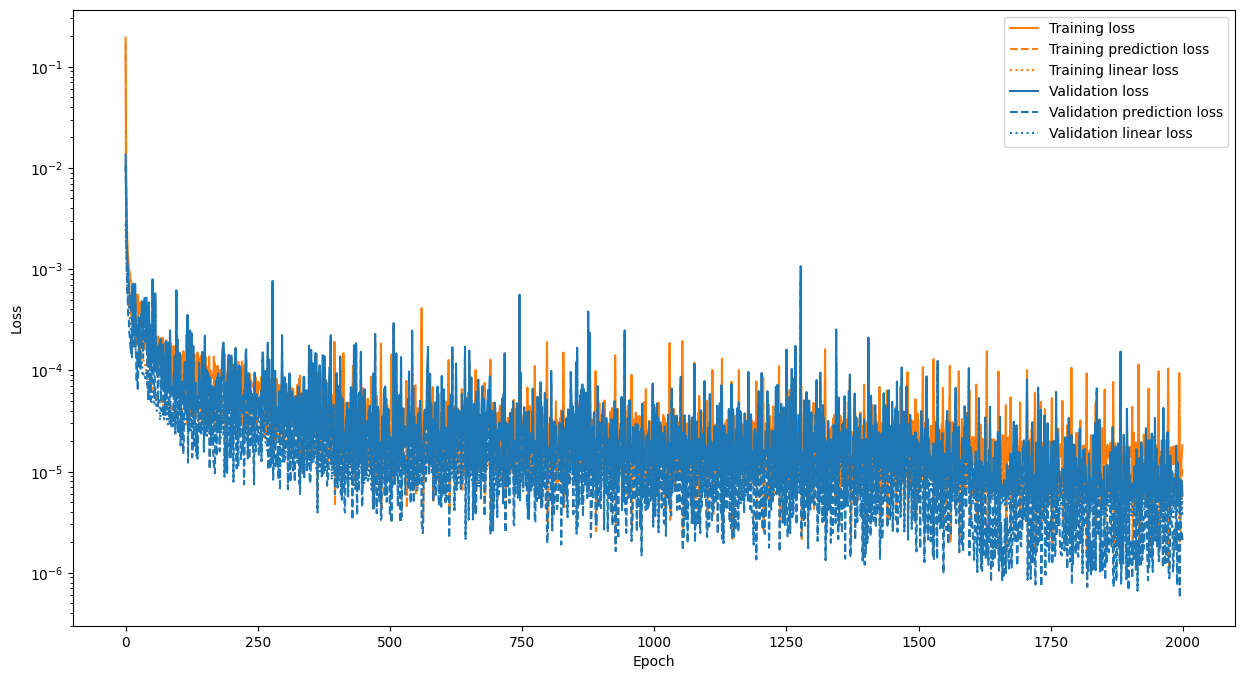

In [57]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lin_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lin_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lin_loss, ':', color='tab:orange', label='Training linear loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lin_loss, ':', color='tab:blue', label='Validation linear loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

### Evaluate open loop prediction performance

We first evaluate the open loop prediction performance of the proposed method.
This is done by generating a new data set in the same way as the training set, predicting the evolution of the system
with the control sequence of each trajectory executed in the data set with each of the models, and finally comparing
the mean and standard deviation of the error between the true and predicted evolution over the trajectories. The
experimental results support what is to be expected from the theory as the error in the $y$ and $z$ terms are
significantly lower for the bEDMD method than both DMD and EDMD. The reason for this
improvement is that the bEDMD method can capture the nonlinearities present in the actuation matrix of the
$(y,z)$-dynamics.

In [58]:
# Prediction performance evaluation parameters:
folder_plots = '/Research'                                  # Path to save plots
n_traj_ol = 100                                                     # Number of trajectories to execute, open loop

In [59]:
# Define file path for loading from Google Drive with the given filename
load_path = 'Research_data/open_loop_prediction_performance.dill'

# Deserialize and load data
with open(load_path, 'rb') as infile:
    loaded_data = dill.load(infile)

# Extract loaded data
xs_test = loaded_data['xs_test']
us_test = loaded_data['us_test']
mdl_lst = loaded_data['mdl_lst']  # Ensure custom classes/functions are defined
mdl_names = loaded_data['mdl_names']
error = loaded_data['error']
mse = loaded_data['mse']
std = loaded_data['std']

print('Data loaded successfully.')


/Users/yoni/Documents/Research/core/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.2.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Data loaded successfully.


In [60]:
# xs_test = np.empty((n_traj_ol, t_eval.shape[0], n))
# us_test = np.empty((n_traj_ol, t_eval.shape[0]-1, m))

# for ii in range(n_traj_ol):
#     x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#     set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#     mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin, umax, xmin, xmax, QN_trajgen, R_trajgen,
#                                 QN_trajgen, set_pt_dc)
#     mpc_trajgen.eval(x0, 0)
#     xd = mpc_trajgen.parse_result().T

#     while xd[0,0] is None:
#         x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#         set_pt_dc = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
#         mpc_trajgen = MPCController(nominal_sys, n_pred_dc, dt, umin-hover_thrust, umax-hover_thrust, xmin, xmax, QN_trajgen, R_trajgen,
#                                     QN_trajgen, set_pt_dc)
#         mpc_trajgen.eval(x0, 0)
#         xd = mpc_trajgen.parse_result().T

#     output = QuadrotorPdOutput(quadrotor, xd, t_eval, n, m)
#     pd_controller = PDController(output, K_dc_p, K_dc_d)
#     perturbed_pd_controller = PerturbedController(quadrotor, pd_controller, noise_var, const_offset=hover_thrust)

#     xs_test[ii,:,:], us_test[ii,:,:] = quadrotor.simulate(x0, perturbed_pd_controller, t_eval)

# mdl_lst = [sys_dmd, sys_edmd, sys_bedmd, sys_koop_dnn]
# mdl_names = ['DMD', 'EDMD', 'bEDMD', 'Koop DNN']
# error, mse, std = [], [], []

# for sys in mdl_lst:
#     err_tmp, mse_tmp, std_tmp = evaluate_ol_pred(sys, xs_test, np.tile(t_eval,(n_traj_ol,1)), us=us_test)
#     error.append(err_tmp)
#     mse.append(mse_tmp)
#     std.append(std_tmp)

print('\nOpen loop performance statistics:')
table_data = []
for name, mse_mdl, std_mdl in zip(mdl_names, mse, std):
    table_data.append([name, "{:.5f}".format(mse_mdl), "{:.5f}".format(std_mdl)])

print(tabulate(table_data,
               headers=['Mean squared error', 'Standard deviation']))


Open loop performance statistics:
            Mean squared error    Standard deviation
--------  --------------------  --------------------
DMD                    0.31114               0.53903
EDMD                   0.04903               0.21932
bEDMD                  0.00904               0.0951
Koop DNN               0.00624               0.07853


In [61]:
# import dill

# # Bundle data into a dictionary
# save_data = {
#     'xs_test': xs_test,
#     'us_test': us_test,
#     'mdl_lst': mdl_lst,  # This may require the models to be serializable
#     'mdl_names': mdl_names,
#     'error': error,
#     'mse': mse,
#     'std': std
# }

# # Define file path for saving in Google Drive with the given filename
# save_path = '/content/drive/My Drive/Research/open_loop_prediction_performance.dill'

# # Serialize and save data
# with open(save_path, 'wb') as outfile:
#     dill.dump(save_data, outfile)

# print(f'Data saved to {save_path}')

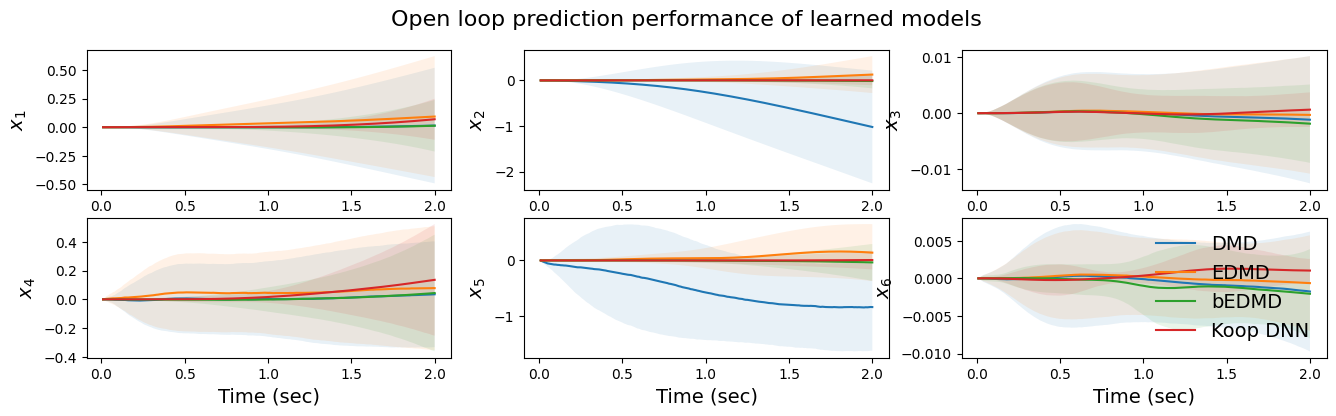

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import math

figwidth = 16
lw = 2
fs = 14
y_lim_gain = 1.2
row = 2


# Correct calculation for the number of columns
col = math.ceil(n / row)

# Plotting open loop results
plt.figure(figsize=(figwidth, 4))
axs = [plt.subplot(row, col, jj + 1) for jj in range(n)]

for ii, err in enumerate(error):
    err_mean = np.mean(err, axis=0)
    err_std = np.std(err, axis=0)

    for jj in range(n):
        axs[jj].plot(t_eval[1:], err_mean[:, jj], label=mdl_names[ii])
        axs[jj].fill_between(t_eval[1:], err_mean[:, jj] - err_std[:, jj], err_mean[:, jj] + err_std[:, jj], alpha=0.1)

for jj in range(n):
    axs[jj].set_xlabel('Time (sec)', fontsize=fs)
    axs[jj].set_ylabel('$x_' + str(jj + 1) + '$', fontsize=fs)

plt.legend(frameon=False, fontsize=fs)
stitle = plt.suptitle('Open loop prediction performance of learned models', fontsize=fs + 2)
plt.show()


# Design trajectories based on learned models

In [63]:
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 4000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [64]:
traj_length=250
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
Q_mpc = sc.sparse.diags([0,0,0,0,0,0])                       # State penalty matrix, trajectory generation
QN_mpc = sc.sparse.diags([1e5,1e5,1e5,1e5,1e5,1e5])         # Final state penalty matrix, trajectory generation
R_mpc = sc.sparse.eye(m)                                     # Actuation penalty matrix, trajectory generation

ctrl_offset = np.array([[hover_thrust], [hover_thrust]])

# Design trajectory:
x0_cl = np.array([-0.8, 0.1, 0.1, -0.3, -0.2, 0.15])                   # Initial value, closed loop trajectory
set_pt_cl = np.array([1.9, 1.2, 0., 0., 0., 0.])              # Desired final value, closed loop trajectory
xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
term_constraint=False

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0_cl, set_pt_cl, int(traj_length)+1)
u_init = np.zeros((m,traj_length)).T

#### Design controllers for learned DMD, EDMD, and bEDMD models

In [65]:

# Define DMD-based controller:
controller_dmd = MPCController(sys_dmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint)

# Define EDMD-based controller:
controller_edmd = MPCController(sys_edmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, terminal_constraint=term_constraint)


In [67]:

# Define bEDMD-based controller:
controller_bedmd = BilinearMPCControllerNb(sys_bedmd, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, solver_settings, terminal_constraint=term_constraint)
z0_bedmd_cl = sys_bedmd.lift(x0_cl.reshape((1,-1)), None).squeeze()
z_init = sys_bedmd.lift(x_init, None)
controller_bedmd.construct_controller(z_init, u_init)

# Define Koop NN controller:
controller_koop_dnn = BilinearMPCControllerNb(sys_koop_dnn, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, solver_settings, terminal_constraint=term_constraint)
z0_koop_dnn_cl = sys_koop_dnn.lift(x0_cl.reshape((1,-1)), None).squeeze()
z_init_koop_dnn = np.array(sys_koop_dnn.lift(x_init, None))
controller_koop_dnn.construct_controller(z_init_koop_dnn, u_init)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 27)

In [ ]:
print(f"z_init shape: {z_init.shape}")
print(f"self.C shape: {controller_bedmd.C.shape}")

z_init shape: (251, 6)
self.C shape: (27, 27)


#### Design controller using full knowledge of nonlinear controller

In [ ]:
quadrotor_d = PlanarQuadrotorForceInputDiscrete(mass, inertia, prop_arm, g=gravity, dt=dt)
controller_nmpc = NonlinearMPCControllerNb(quadrotor_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt_cl, solver_settings, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init)

#### Design trajectories with the contructed MPCs

In [ ]:
max_iter = 100

controller_dmd.eval(x0_cl, 0)
xr_dmd = controller_dmd.parse_result()
ur_dmd = controller_dmd.get_control_prediction()

controller_edmd.eval(x0_cl, 0)
xr_edmd = sys_edmd.C@controller_edmd.parse_result()
ur_edmd = controller_edmd.get_control_prediction()

controller_bedmd.solve_to_convergence(z0_bedmd_cl, 0., z_init, u_init, max_iter=max_iter)
xr_bedmd = controller_bedmd.get_state_prediction().T
ur_bedmd = controller_bedmd.get_control_prediction().T

controller_koop_dnn.solve_to_convergence(z0_koop_dnn_cl, 0., z_init_koop_dnn, u_init, max_iter=max_iter)
xr_koop_dnn = controller_koop_dnn.get_state_prediction().T
ur_koop_dnn = controller_koop_dnn.get_control_prediction().T

controller_nmpc.solve_to_convergence(x0_cl, 0., x_init, u_init, max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

In [ ]:
#controller_nmpc.solve_to_convergence(x0_cl, 0., x_init, u_init, max_iter=max_iter)
#xr_nmpc = controller_nmpc.get_state_prediction().T
#ur_nmpc = controller_nmpc.get_control_prediction().T

## Simulate designed trajectories open loop

In [ ]:
ol_controller_dmd = OpenLoopController(quadrotor, ur_dmd.T, t_eval[:-1])
xs_dmd, us_dmd = quadrotor.simulate(x0_cl, ol_controller_dmd, t_eval)
xs_dmd, us_dmd = xs_dmd.T, us_dmd.T

ol_controller_edmd = OpenLoopController(quadrotor, ur_edmd.T, t_eval[:-1])
xs_edmd, us_edmd = quadrotor.simulate(x0_cl, ol_controller_edmd, t_eval)
xs_edmd, us_edmd = xs_edmd.T, us_edmd.T

ol_controller_bedmd = OpenLoopController(quadrotor, ur_bedmd.T, t_eval[:-1])
xs_bedmd, us_bedmd = quadrotor.simulate(x0_cl, ol_controller_bedmd, t_eval)
xs_bedmd, us_bedmd = xs_bedmd.T, us_bedmd.T

ol_controller_koop_dnn = OpenLoopController(quadrotor, ur_koop_dnn.T, t_eval[:-1])
xs_koop_dnn, us_koop_dnn = quadrotor.simulate(x0_cl, ol_controller_koop_dnn, t_eval)
xs_koop_dnn, us_koop_dnn = xs_koop_dnn.T, us_koop_dnn.T

ol_controller_nmpc = OpenLoopController(quadrotor, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = quadrotor.simulate(x0_cl, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

## Compare Perfromance

In [ ]:
import matplotlib.pyplot as plt
plot_inds = [0, 1, 2, 3, 4, 5, 0, 1]
subplot_inds = [1, 2, 3, 5, 6, 7, 4, 8]
labels = ['$y$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{y}$ (m/s)','$\\dot{z}$ (m/s)', '$\\dot{\\theta}$', '$T_1$ (N)','$T_2$ (N)']
titles = ['y-coordinates', 'z-coordinates', '$\\theta$-coordinates', 'Control inputs']
colors = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:green', 'tab:cyan']

plt.figure(figsize=(12,4))
for ii in range(8):
    ind = plot_inds[ii]
    if ii < 6:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval, xr_dmd[ind,:], colors[0], label='DMD MPC')
        plt.plot(t_eval, xr_edmd[ind, :], colors[1], label='EDMD MPC')
        plt.plot(t_eval, xr_bedmd[ind, :], colors[2], label='bEDMD NMPC')
        plt.plot(t_eval, xr_koop_dnn[ind, :], colors[3], label='Koop NN NMPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[4], label='NMPC')

        plt.plot(t_eval, xs_dmd[ind,:], '--', color=colors[0], linewidth=1)
        plt.plot(t_eval, xs_edmd[ind, :], '--', color=colors[1], linewidth=1)
        plt.plot(t_eval, xs_bedmd[ind, :], '--', color=colors[2], linewidth=1)
        plt.plot(t_eval, xs_koop_dnn[ind, :], '--', color=colors[3], linewidth=1)
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[4], linewidth=1)

        plt.scatter(t_eval[0], x0_cl[ind], color='g')
        plt.scatter(t_eval[-1], set_pt_cl[ind], color='r')
        plt.ylabel(labels[ind])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if ii >= 3:
            plt.plot([0, t_eval[-1]], [xmax[ind], xmax[ind]], ':k')
            plt.plot([0, t_eval[-1]], [xmin[ind], xmin[ind]], ':k')
        if subplot_inds[ii]==1:
            plt.legend(loc='upper left', frameon=False)
    elif ii < 8:
        ax = plt.subplot(2,4,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_dmd[ind,:], color=colors[0], label='DMD MPC')
        plt.plot(t_eval[:-1], ur_edmd[ind, :], color=colors[1], label='EDMD MPC')
        plt.plot(t_eval[:-1], ur_bedmd[ind, :], color=colors[2], label='bEDMD NMPC')
        plt.plot(t_eval[:-1], ur_koop_dnn[ind, :], color=colors[3], label='Koop NN NMPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[4], label='NMPC')
        plt.plot([0, t_eval[-1]], [umax[ind], umax[ind]], ':k')
        plt.plot([0, t_eval[-1]], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    if subplot_inds[ii] > 4:
        plt.xlabel('Time (sec)')
    else:
        plt.title(titles[subplot_inds[ii]-1])

if save_figures:
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig(model_fname + 'planar_quad_trajectory.pdf', format='pdf', dpi=2400)
plt.show()

cost_ref_dmd = (xr_dmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_dmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_dmd.T@R_mpc@ur_dmd))
cost_ref_edmd = (xr_edmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_edmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_edmd.T@R_mpc@ur_edmd))
cost_ref_bedmd = (xr_bedmd[:,-1]-set_pt_cl).T@QN_mpc@(xr_bedmd[:,-1]-set_pt_cl) + np.sum(np.diag(ur_bedmd.T@R_mpc@ur_bedmd))
cost_ref_koop_dnn = (xr_koop_dnn[:,-1]-set_pt_cl).T@QN_mpc@(xr_koop_dnn[:,-1]-set_pt_cl) + np.sum(np.diag(ur_koop_dnn.T@R_mpc@ur_koop_dnn))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt_cl).T@QN_mpc@(xr_nmpc[:,-1]-set_pt_cl) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

dist_ol_dmd = np.linalg.norm(xs_dmd[:,-1] - set_pt_cl)
dist_ol_edmd = np.linalg.norm(xs_edmd[:,-1] - set_pt_cl)
dist_ol_bedmd = np.linalg.norm(xs_bedmd[:,-1] - set_pt_cl)
dist_ol_koop_dnn = np.linalg.norm(xs_koop_dnn[:,-1] - set_pt_cl)
dist_ol_nmpc = np.linalg.norm(xs_nmpc[:,-1] - set_pt_cl)

print('Solution statistics:\n')
print(tabulate([['DMD MPC', "{:.4f}".format(cost_ref_dmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_dmd), '-','-',sum(controller_dmd.comp_time)],
                ['EDMD MPC', "{:.4f}".format(cost_ref_edmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_edmd),'-','-',sum(controller_edmd.comp_time)],
                ['bEDMD NMPC', "{:.4f}".format(cost_ref_bedmd/cost_ref_nmpc), "{:.4f}".format(dist_ol_bedmd), len(controller_bedmd.x_iter), "{:.4f}".format(np.mean(controller_bedmd.comp_time)), sum(controller_bedmd.comp_time)],
                ['Koop NN NMPC', "{:.4f}".format(cost_ref_koop_dnn/cost_ref_nmpc), "{:.4f}".format(dist_ol_koop_dnn), len(controller_koop_dnn.x_iter), "{:.4f}".format(np.mean(controller_koop_dnn.comp_time)), sum(controller_koop_dnn.comp_time)],
                ['NMPC (benchmark)', 1, "{:.4f}".format(dist_ol_nmpc), len(controller_nmpc.x_iter), "{:.4f}".format(np.mean(controller_nmpc.comp_time)), sum(controller_nmpc.comp_time)]],
               headers=['Normalized cost,\ndesigned trajectory', 'Realized terminal,\nerror', '# of SQP\niterations','Mean comp. time\nper iteration (secs)', 'Total comp.\ntime (secs)']))

In [ ]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_bedmd.x_iter))

# Calculate cost after each iteration:
iter_cost_bedmd, iter_cost_nmpc = [], []

ol_controller_init = OpenLoopController(quadrotor, u_init, t_eval[:-1])
xs_init, _ = quadrotor.simulate(x0_cl, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T
init_cost = (xs_init[:,-1]-set_pt_cl).T@QN_mpc@(xs_init[:,-1]-set_pt_cl) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_bedmd = [init_cost]
iter_cost_koop_dnn = [init_cost]
iter_cost_nmpc = [init_cost]
iter_norm_dist_bedmd = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]
iter_norm_dist_koop_dnn = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]
iter_norm_dist_nmpc = [np.linalg.norm(xs_init[:,-1]-set_pt_cl)]

for ii in range(len(controller_bedmd.x_iter)):
    ur_bedmd_iter = controller_bedmd.u_iter[ii].T
    ol_controller_bedmd_iter = OpenLoopController(quadrotor, ur_bedmd_iter, t_eval[:-1])
    xs_bedmd_iter, _ = quadrotor.simulate(x0_cl, ol_controller_bedmd_iter, t_eval)
    xs_bedmd_iter, us_bedmd_iter = xs_bedmd_iter.T, ur_bedmd_iter.T
    iter_cost_bedmd.append((xs_bedmd_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_bedmd_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_bedmd_iter.T@R_mpc@us_bedmd_iter)))
    iter_norm_dist_bedmd.append(np.linalg.norm(xs_bedmd_iter[:,-1]-set_pt_cl))

for ii in range(len(controller_bedmd.x_iter)):
    ur_koop_dnn_iter = controller_koop_dnn.u_iter[ii].T
    ol_controller_koop_dnn_iter = OpenLoopController(quadrotor, ur_koop_dnn_iter, t_eval[:-1])
    xs_koop_dnn_iter, _ = quadrotor.simulate(x0_cl, ol_controller_koop_dnn_iter, t_eval)
    xs_koop_dnn_iter, us_koop_dnn_iter = xs_koop_dnn_iter.T, ur_koop_dnn_iter.T
    iter_cost_koop_dnn.append((xs_koop_dnn_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_koop_dnn_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_koop_dnn_iter.T@R_mpc@us_koop_dnn_iter)))
    iter_norm_dist_koop_dnn.append(np.linalg.norm(xs_koop_dnn_iter[:,-1]-set_pt_cl))

for ii in range(len(controller_nmpc.x_iter)):
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(quadrotor, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = quadrotor.simulate(x0_cl, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt_cl).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt_cl) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))
    iter_norm_dist_nmpc.append(np.linalg.norm(xs_nmpc_iter[:,-1]-set_pt_cl))

In [ ]:
plt.figure(figsize=(6,4))
plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
plt.subplot(2,1,1)
plt.plot(np.arange(n_iter), iter_cost_bedmd[:n_iter]/iter_cost_nmpc[-1], color=colors[2], label='bEDMD NMPC')
plt.plot(np.arange(n_iter), iter_cost_koop_dnn[:n_iter]/iter_cost_nmpc[-1], color=colors[3], label='Koop NN NMPC')
plt.plot(np.arange(n_iter), iter_cost_nmpc[:n_iter]/iter_cost_nmpc[-1], color=colors[4], label='NMPC')
plt.ylim(0,5)
plt.title('Control effort')
plt.ylabel('$||u||$')
plt.legend(loc='upper right', frameon=False)
plt.xlabel('SQP iteration')

plt.subplot(2,1,2)
plt.plot(np.arange(n_iter), iter_norm_dist_bedmd[:n_iter], color=colors[2])
plt.plot(np.arange(n_iter), iter_norm_dist_koop_dnn[:n_iter], color=colors[3])
plt.plot(np.arange(n_iter), iter_norm_dist_nmpc[:n_iter], color=colors[4])
plt.ylim(0,5)
plt.title('Realized terminal distance from setpoint')
plt.ylabel('$||x_N - x_d||$')
plt.xlabel('SQP iteration')

if save_figures:
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.tight_layout()
    plt.savefig( model_fname + 'planar_quad_sqp_iterations.pdf', format='pdf', dpi=2400)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_bedmd.x_iter), np.mean(controller_bedmd.comp_time), np.std(controller_bedmd.comp_time), sum(controller_bedmd.comp_time)]],
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

### Design finite horizon controllers

In [ ]:
#from koopman_core.controllers import PerturbedController

Q_mpc_cl = sc.sparse.diags([1e3, 1e3, 1e3, 1e2, 1e2, 1e2])
QN_mpc_cl = Q_mpc_cl
R_mpc_cl = sc.sparse.eye(m)
traj_duration = 0.5
N_cl = int(traj_duration/dt)
t_eval_cl=np.arange(250)*dt

solver_settings_cl = solver_settings

In [ ]:
controller_dmd_cl = MPCController(sys_dmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_dmd_cl = PerturbedController(sys_dmd,controller_dmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_edmd_cl = MPCController(sys_edmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, add_slack=True)
controller_edmd_cl = PerturbedController(sys_edmd,controller_edmd_cl,0.,const_offset=hover_thrust, umin=umin, umax=umax)

controller_bedmd_cl = BilinearMPCControllerNb(sys_bedmd, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, solver_settings_cl, add_slack=True)
controller_bedmd_cl.construct_controller(controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:])
controller_bedmd_cl.solve_to_convergence(z0_bedmd_cl, 0., controller_bedmd.cur_z[:N_cl+1,:], controller_bedmd.cur_u[:N_cl,:], max_iter=max_iter)
_ = controller_bedmd_cl.eval(x0_cl, 0.)
controller_bedmd_cl = PerturbedController(sys_bedmd,controller_bedmd_cl,0., umin=umin, umax=umax)

controller_koop_dnn_cl = BilinearMPCControllerNb(sys_koop_dnn, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, solver_settings_cl, add_slack=True)
controller_koop_dnn_cl.construct_controller(controller_koop_dnn.cur_z[:N_cl+1,:], controller_koop_dnn.cur_u[:N_cl,:])
controller_koop_dnn_cl.solve_to_convergence(z0_koop_dnn_cl, 0., controller_koop_dnn.cur_z[:N_cl+1,:], controller_koop_dnn.cur_u[:N_cl,:], max_iter=max_iter)
_ = controller_koop_dnn_cl.eval(x0_cl, 0.)
controller_koop_dnn_cl = PerturbedController(sys_koop_dnn,controller_koop_dnn_cl,0.)

controller_nmpc_cl = NonlinearMPCControllerNb(quadrotor_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt_cl, solver_settings_cl, add_slack=True)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])
controller_nmpc_cl.solve_to_convergence(x0_cl, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)
_ = controller_nmpc_cl.eval(x0_cl, 0.)